In [1]:
#*****************************************************************
#If you have any questions please use Q&A section on www.udemy.com
#Author - jaro.algo@icloud.com
#*****************************************************************

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [3]:
plt.style.use('ggplot')

In [4]:
pairs_list = [
    'EURUSD/EURUSD_H1 - EURUSD_H1',
    'AUDUSD/AUDUSD_H1 - AUDUSD_H1',
    'GBPUSD/GBPUSD_H1 - GBPUSD_H1',
    'NZDUSD/NZDUSD_H1 - NZDUSD_H1',
    'USDCAD/USDCAD_H1 - USDCAD_H1',
    'USDCHF/USDCHF_H1 - USDCHF_H1',
    'USDJPY/USDJPY_H1 - USDJPY_H1',
    'XAUUSD/XAUUSD_H1 - XAUUSD_H1',
]

In [5]:
# pairs_list = []
# for filename in os.listdir(path):
#     if filename.endswith('.csv'):
#         pairs_list.append(filename.split('.')[0])
# print(pairs_list)

# df = {}
# for pair in range(len(pairs_list)):
#     df[pair] = pd.read_csv(pairs_list[pair]+'.csv', header = 0)
#     df[pair].columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
#     df[pair]['Date'] = df[pair]['Date'].str.split(' ').str[0:2]
#     df[pair]['Date'] = df[pair]['Date'].str.join(' ')
#     df[pair].set_index('Date', inplace = True)
#     df[pair].index = pd.to_datetime(df[pair].index, format = '%d.%m.%Y %H:%M:%S.%f')
#     df[pair]['Day'] = df[pair].index.dayofweek
#     dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
#     df[pair]['Day'] = df[pair]['Day'].map(dmap)

In [6]:
df ={}
for pair in range(len(pairs_list)) :
    df[pair] = pd.read_csv('../../Data_Forex/'+pairs_list[pair]+'.csv',index_col=0,parse_dates=True)
    df[pair]['Day'] = df[pair].index.dayofweek
    dmap = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    df[pair]['Day'] = df[pair]['Day'].map(dmap)
    df[pair].index = pd.to_datetime(df[pair].index, format = '%Y-%m-%d %H:%M:%S.%f')

In [7]:
df[0]

Open     High      Low    Close  Volume  Day
Time                                                                
2007-03-05 12:00:00  1.30956  1.31041  1.30804  1.30836   48375  Mon
2007-03-05 13:00:00  1.30847  1.30957  1.30749  1.30842   47309  Mon
2007-03-05 14:00:00  1.30825  1.31002  1.30723  1.30968   45678  Mon
2007-03-05 15:00:00  1.30986  1.31145  1.30968  1.30979   44625  Mon
2007-03-05 16:00:00  1.30960  1.31112  1.30883  1.30921  444359  Mon
...                      ...      ...      ...      ...     ...  ...
2023-03-10 12:00:00  1.05896  1.05984  1.05806  1.05941   21131  Fri
2023-03-10 13:00:00  1.05940  1.06440  1.05817  1.06216   58676  Fri
2023-03-10 14:00:00  1.06215  1.06743  1.06119  1.06662   79179  Fri
2023-03-10 15:00:00  1.06664  1.07004  1.06664  1.06872   60325  Fri
2023-03-10 16:00:00  1.06873  1.06873  1.06551  1.06585   43114  Fri

[100009 rows x 6 columns]

In [8]:
#Strategy parameters
account_size = 1000
slippage = 2
size = 1
ATR_SL = 0.5
entry_time = 8

In [9]:
def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [10]:


for pair in range(len(pairs_list)):
    df[pair]['ATR'] = ATR(df[pair], 20)['ATR']
    df[pair]['london_opening'] = np.where((df[pair].index.hour + 1) == entry_time, True, False)
    if 'JPY' not in pairs_list[pair]:
        df[pair]['spread'] = float(slippage) / float(10000)
        df[pair]['size'] = float(size) * float(10000)
        print('Pair: ', pairs_list[pair], 'a')
    else:
        df[pair]['spread'] = float(slippage) / float(100)
        df[pair]['size'] = float(size) * float(100)
        print('Pair: ', pairs_list[pair], 'b')

Pair:  EURUSD/EURUSD_H1 - EURUSD_H1 a
Pair:  AUDUSD/AUDUSD_H1 - AUDUSD_H1 a
Pair:  GBPUSD/GBPUSD_H1 - GBPUSD_H1 a
Pair:  NZDUSD/NZDUSD_H1 - NZDUSD_H1 a
Pair:  USDCAD/USDCAD_H1 - USDCAD_H1 a
Pair:  USDCHF/USDCHF_H1 - USDCHF_H1 a
Pair:  USDJPY/USDJPY_H1 - USDJPY_H1 b
Pair:  XAUUSD/XAUUSD_H1 - XAUUSD_H1 a


In [11]:
open_trade = {}
trade = {}
long_take_profit = {}
short_take_profit = {}
long_stop_loss = {}
short_stop_loss = {}
long_entry_price = {}
short_entry_price = {}

for pair in range(len(pairs_list)):
    open_trade[pair] = []
    trade[pair] = {}
    long_take_profit[pair] = []
    short_take_profit[pair] = []
    long_stop_loss[pair] = []
    short_stop_loss[pair] = []
    long_entry_price[pair] = []
    short_entry_price[pair] = []
    
    for i in range(50, len(df[pair])):
        #Buy
        if df[pair]['london_opening'][i] == True and df[pair]['Close'][i] >= df[pair]['Close'].rolling(8).max()[i] and len(open_trade[pair]) == 0:
            print(i, 'New Long trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Buy',
                              'result': 0,
                              'TP': df[pair]['Close'][i] + df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] - df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            long_take_profit[pair].append(trade[pair][i]['TP'])
            long_stop_loss[pair].append(trade[pair][i]['SL'])
            long_entry_price[pair].append(trade[pair][i]['entry_price'])
        
        #Sell
        if df[pair]['london_opening'][i] == True and df[pair]['Close'][i] <= df[pair]['Close'].rolling(8).min()[i] and len(open_trade[pair]) == 0:
            print(i, 'New Short trade at price:', round(df[pair]['Close'][i], 4), ' On day:', df[pair].index[i], 'Pair:', pairs_list[pair])
            trade[pair][i] = {'ID': i,
                              'date_of_trade': df[pair].index[i],
                              'day_of_trade': df[pair]['Day'][i],
                              'entry_price': df[pair]['Close'][i],
                              'signal': 'Sell',
                              'result': 0,
                              'TP': df[pair]['Close'][i] - df[pair]['ATR'][i] * 5 * ATR_SL,
                              'SL': df[pair]['Close'][i] + df[pair]['ATR'][i] * ATR_SL}
            open_trade[pair].append(i)
            short_take_profit[pair].append(trade[pair][i]['TP'])
            short_stop_loss[pair].append(trade[pair][i]['SL'])
            short_entry_price[pair].append(trade[pair][i]['entry_price'])
            
        #Exit trades---------------------------------------------------------------------------
        #Buy Trailing SL
        if any(y <= df[pair]['Close'][i] for y in long_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    #Move SL to BE
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + df[pair]['spread'][i]})
                        print(j, 
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_entry_price[pair] = []
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to second ATR
                    if df[pair]['Close'][i] >= trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 3 * ATR_SL):
                        long_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] + (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        long_stop_loss[pair].append(trade[pair][j]['SL'])
        #Sell Trailing SL
        if any(y >= df[pair]['Close'][i] for y in short_entry_price[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    #Move SL to BE
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - df[pair]['spread'][i]})
                        print(j, 
                             'Moved SL to BE:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_entry_price[pair] = []
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                    #Move SL to first ATR
                    if df[pair]['Close'][i] <= trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 3 * ATR_SL):
                        short_stop_loss[pair] = []
                        trade[pair][j].update({'SL' : trade[pair][j]['entry_price'] - (df[pair]['ATR'][i] * 2 * ATR_SL)})
                        print(j, 
                             'Trailing SL to first ATR:', round(trade[pair][j]['SL'], 4),
                             'On day:', df[pair].index[i], '\n')
                        short_stop_loss[pair].append(trade[pair][j]['SL'])
                        
        #Buy profit
        if any(y <= df[pair]['Close'][i] for y in long_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] >= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['TP'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Buy loss
        if any(y >= df[pair]['Close'][i] for y in long_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    if df[pair]['Close'][i] <= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['SL'] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Long loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        long_take_profit[pair].remove(trade[pair][j]['TP'])
                        long_stop_loss[pair].remove(trade[pair][j]['SL'])
                        
        #Sell profit
        if any(y >= df[pair]['Close'][i] for y in short_take_profit[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] <= trade[pair][j]['TP']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['TP'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short profit at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With profit:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Sell loss
        if any(y <= df[pair]['Close'][i] for y in short_stop_loss[pair]):
            for j in open_trade[pair]:
                if trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    if df[pair]['Close'][i] >= trade[pair][j]['SL']:
                        trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - trade[pair][j]['SL'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                        print(j, 
                             'Short loss at price:', round(df[pair]['Close'][i], 4),
                             'On day:', df[pair].index[i],
                             'With loss:', round(trade[pair][j]['result'], 4), '\n')
                        open_trade[pair].remove(j)
                        short_take_profit[pair].remove(trade[pair][j]['TP'])
                        short_stop_loss[pair].remove(trade[pair][j]['SL'])
        #Exit after time
        if len(open_trade[pair]) != 0:
            for j in open_trade[pair]:
                if (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Buy':
                    trade[pair][j].update({'result' : (df[pair]['Close'][i] - trade[pair][j]['entry_price'] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Long exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    long_take_profit[pair].remove(trade[pair][j]['TP'])
                    long_stop_loss[pair].remove(trade[pair][j]['SL'])
                elif (i - trade[pair][j]['ID']) >= 12 and trade[pair][j].get('result', {}) == 0 and trade[pair][j].get('signal', {}) == 'Sell':
                    trade[pair][j].update({'result' : (trade[pair][j]['entry_price'] - df[pair]['Close'][i] - df[pair]['spread'][i]) * df[pair]['size'][i]})
                    print(j, 
                         'Short exited after 12 hours:', round(df[pair]['Close'][i], 4),
                         'On day:', df[pair].index[i],
                         'With profit:', round(trade[pair][j]['result'], 4), '\n')
                    open_trade[pair].remove(j)
                    short_take_profit[pair].remove(trade[pair][j]['TP'])
                    short_stop_loss[pair].remove(trade[pair][j]['SL'])

116 New Long trade at price: 1.3125  On day: 2007-03-12 07:00:00 Pair: EURUSD/EURUSD_H1 - EURUSD_H1
116 Moved SL to BE: 1.3127 On day: 2007-03-12 08:00:00 

116 Trailing SL to first ATR: 1.3133 On day: 2007-03-12 08:00:00 

116 Long profit at price: 1.3169 On day: 2007-03-12 09:00:00 With profit: 40.7125 

140 New Short trade at price: 1.3165  On day: 2007-03-13 07:00:00 Pair: EURUSD/EURUSD_H1 - EURUSD_H1
140 Moved SL to BE: 1.3163 On day: 2007-03-13 09:00:00 

140 Short loss at price: 1.317 On day: 2007-03-13 10:00:00 With loss: -0.0 

188 New Short trade at price: 1.3213  On day: 2007-03-15 07:00:00 Pair: EURUSD/EURUSD_H1 - EURUSD_H1
188 Moved SL to BE: 1.3211 On day: 2007-03-15 10:00:00 

188 Short loss at price: 1.3218 On day: 2007-03-15 11:00:00 With loss: -0.0 

212 New Long trade at price: 1.3306  On day: 2007-03-16 07:00:00 Pair: EURUSD/EURUSD_H1 - EURUSD_H1
212 Moved SL to BE: 1.3308 On day: 2007-03-16 09:00:00 

212 Long loss at price: 1.3305 On day: 2007-03-16 15:00:00 With 

In [12]:
pairs_results = {}
profits = {}
losses = {}
be = {}

for pair in range(len(pairs_list)):
    profits[pair] = []
    losses[pair] = []
    be[pair] = []
    
    pairs_results[pair] = pd.DataFrame.from_dict({(i, j): trade[pair][j] for j in trade[pair].keys()}, orient = 'index')
    pairs_results[pair] = pairs_results[pair].drop(['signal', 'ID', 'TP', 'SL'], axis = 1)
    pairs_results[pair].set_index('date_of_trade', inplace = True)
    pairs_results[pair]['cum_res'] = pairs_results[pair]['result'].cumsum() + account_size
    
    for t in trade[pair]:
        profits[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] > 0.1 else ''
        losses[pair].append(trade[pair][t]['result']) if trade[pair][t]['result'] < -0.1 else ''
        be[pair].append(trade[pair][t]['result']) if -0.1 <= trade[pair][t]['result'] <= 0.1 else ''
        
my_reduce = partial(pd.merge, on = 'date_of_trade', how = 'outer')
strategy_results = reduce(my_reduce, pairs_results.values())
strategy_results = strategy_results.sort_index()
strategy_results['final_res'] = strategy_results.filter(like = 'result', axis = 1).sum(axis = 1)
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

profits_keys = list(profits.keys())
profits_values = [profits[x] for x in profits_keys]
str_profits = list(flatten(profits_values))

losses_keys = list(losses.keys())
losses_values = [losses[x] for x in losses_keys]
str_losses = list(flatten(losses_values))

be_keys = list(be.keys())
be_values = [be[x] for x in be_keys]
str_be = list(flatten(be_values))

C:\Users\Win10\AppData\Local\Temp\ipykernel_12732\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'day_of_trade_x', 'result_x', 'cum_res_x', 'entry_price_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_12732\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'day_of_trade_x', 'result_x', 'cum_res_x', 'entry_price_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())
C:\Users\Win10\AppData\Local\Temp\ipykernel_12732\518135374.py:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'day_of_trade_x', 'result_x', 'cum_res_x', 'entry_price_x'} in the result is deprecated and will raise a MergeError in a future version.
  strategy_results = reduce(my_reduce, pairs_results.values())


Text(0.5, 1.0, 'Returns of each pair')

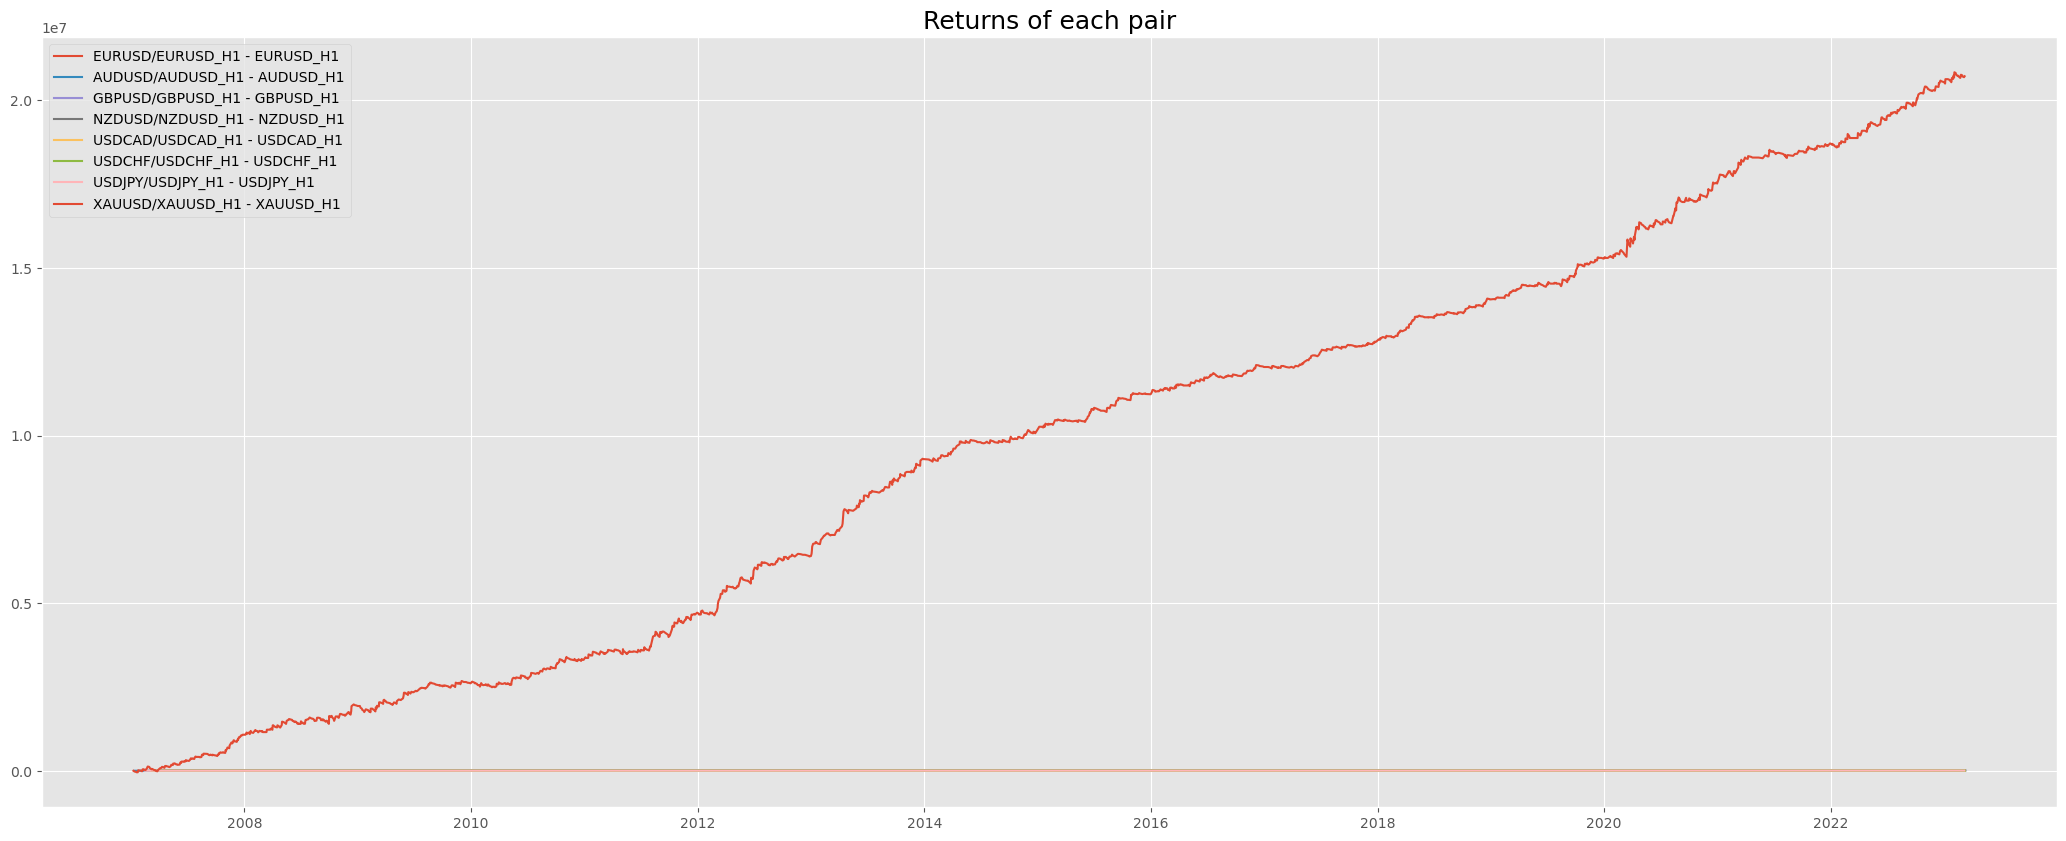

In [13]:
plt.figure(figsize = (26, 10))
for pair in range(len(pairs_list)):
    plt.plot(pairs_results[pair]['cum_res'], label = pairs_list[pair])
plt.legend()
plt.title('Returns of each pair', fontsize = 18)

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: 58.7 %
Sharpe ratio: -0.01
Maximum drawdown 457.04 % 

Number of trades: 16826
Number of profits: 5272
Number of losses: 8383
Number of breakevens: 3171 

Winning percentage 38.61 %
ROI: 20758067
--------------------------------
Average profitable trade: 7482.36
Average lossing trade: -2229.38
Max profitable trade: 514009.25
Max lossing trade: -88750.0


c:\Users\Win10\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Text(0.5, 1.0, 'return of strategy')

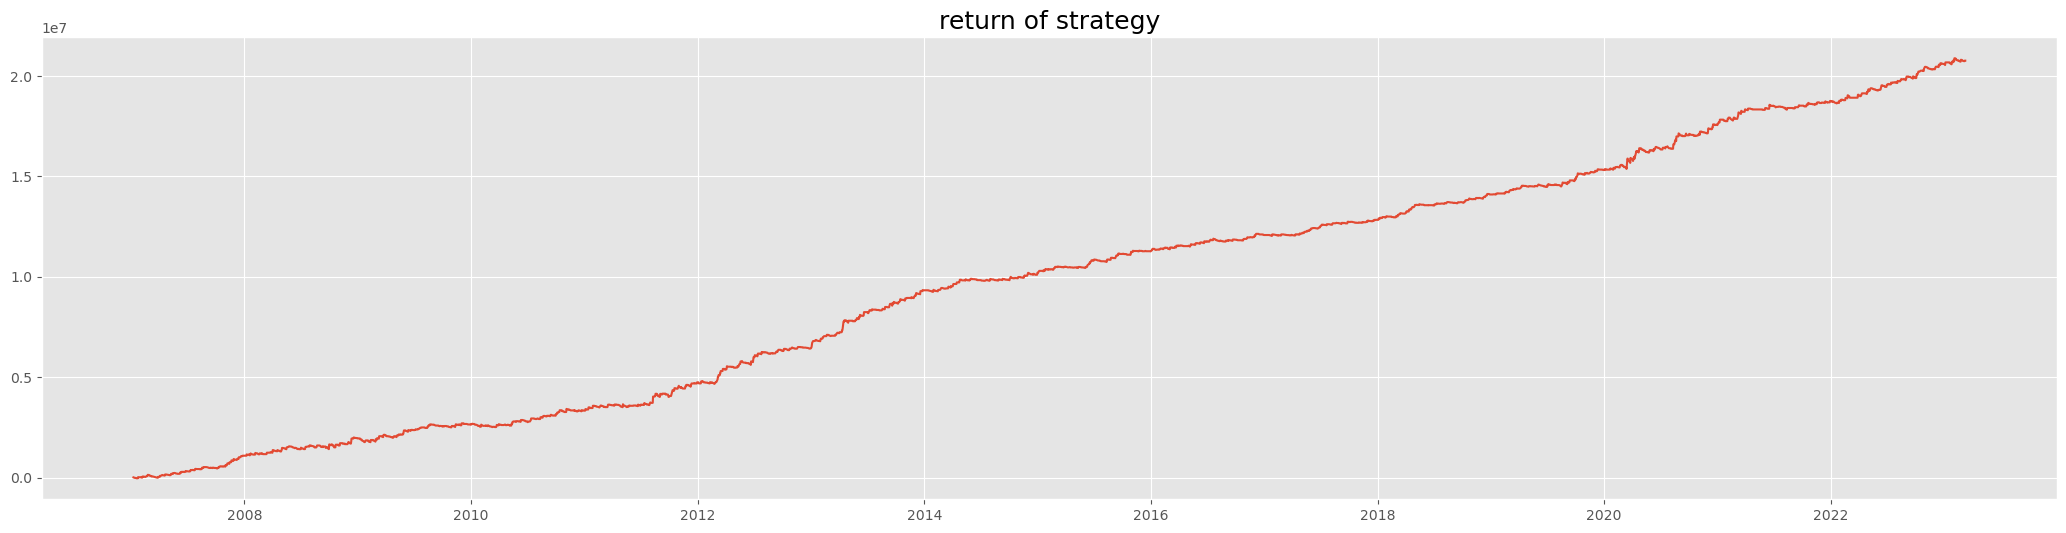

In [14]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df[0]), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)

EURUSD/EURUSD_H1 - EURUSD_H1 - PERFORMANCE
--------------------------------
Number of trades: 2256
Number of profits: 716
Number of losses: 1155
Number of breakevens: 385 

Winning percentage 38.27 %
ROI: 8435.97
--------------------------------
Average profitable trade: 30.35
Average lossing trade: -11.51
Max profitable trade: 158.51
Max lossing trade: -40.8
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    420
Mon    465
Thu    461
Tue    470
Wed    440
Name: result, dtype: int64


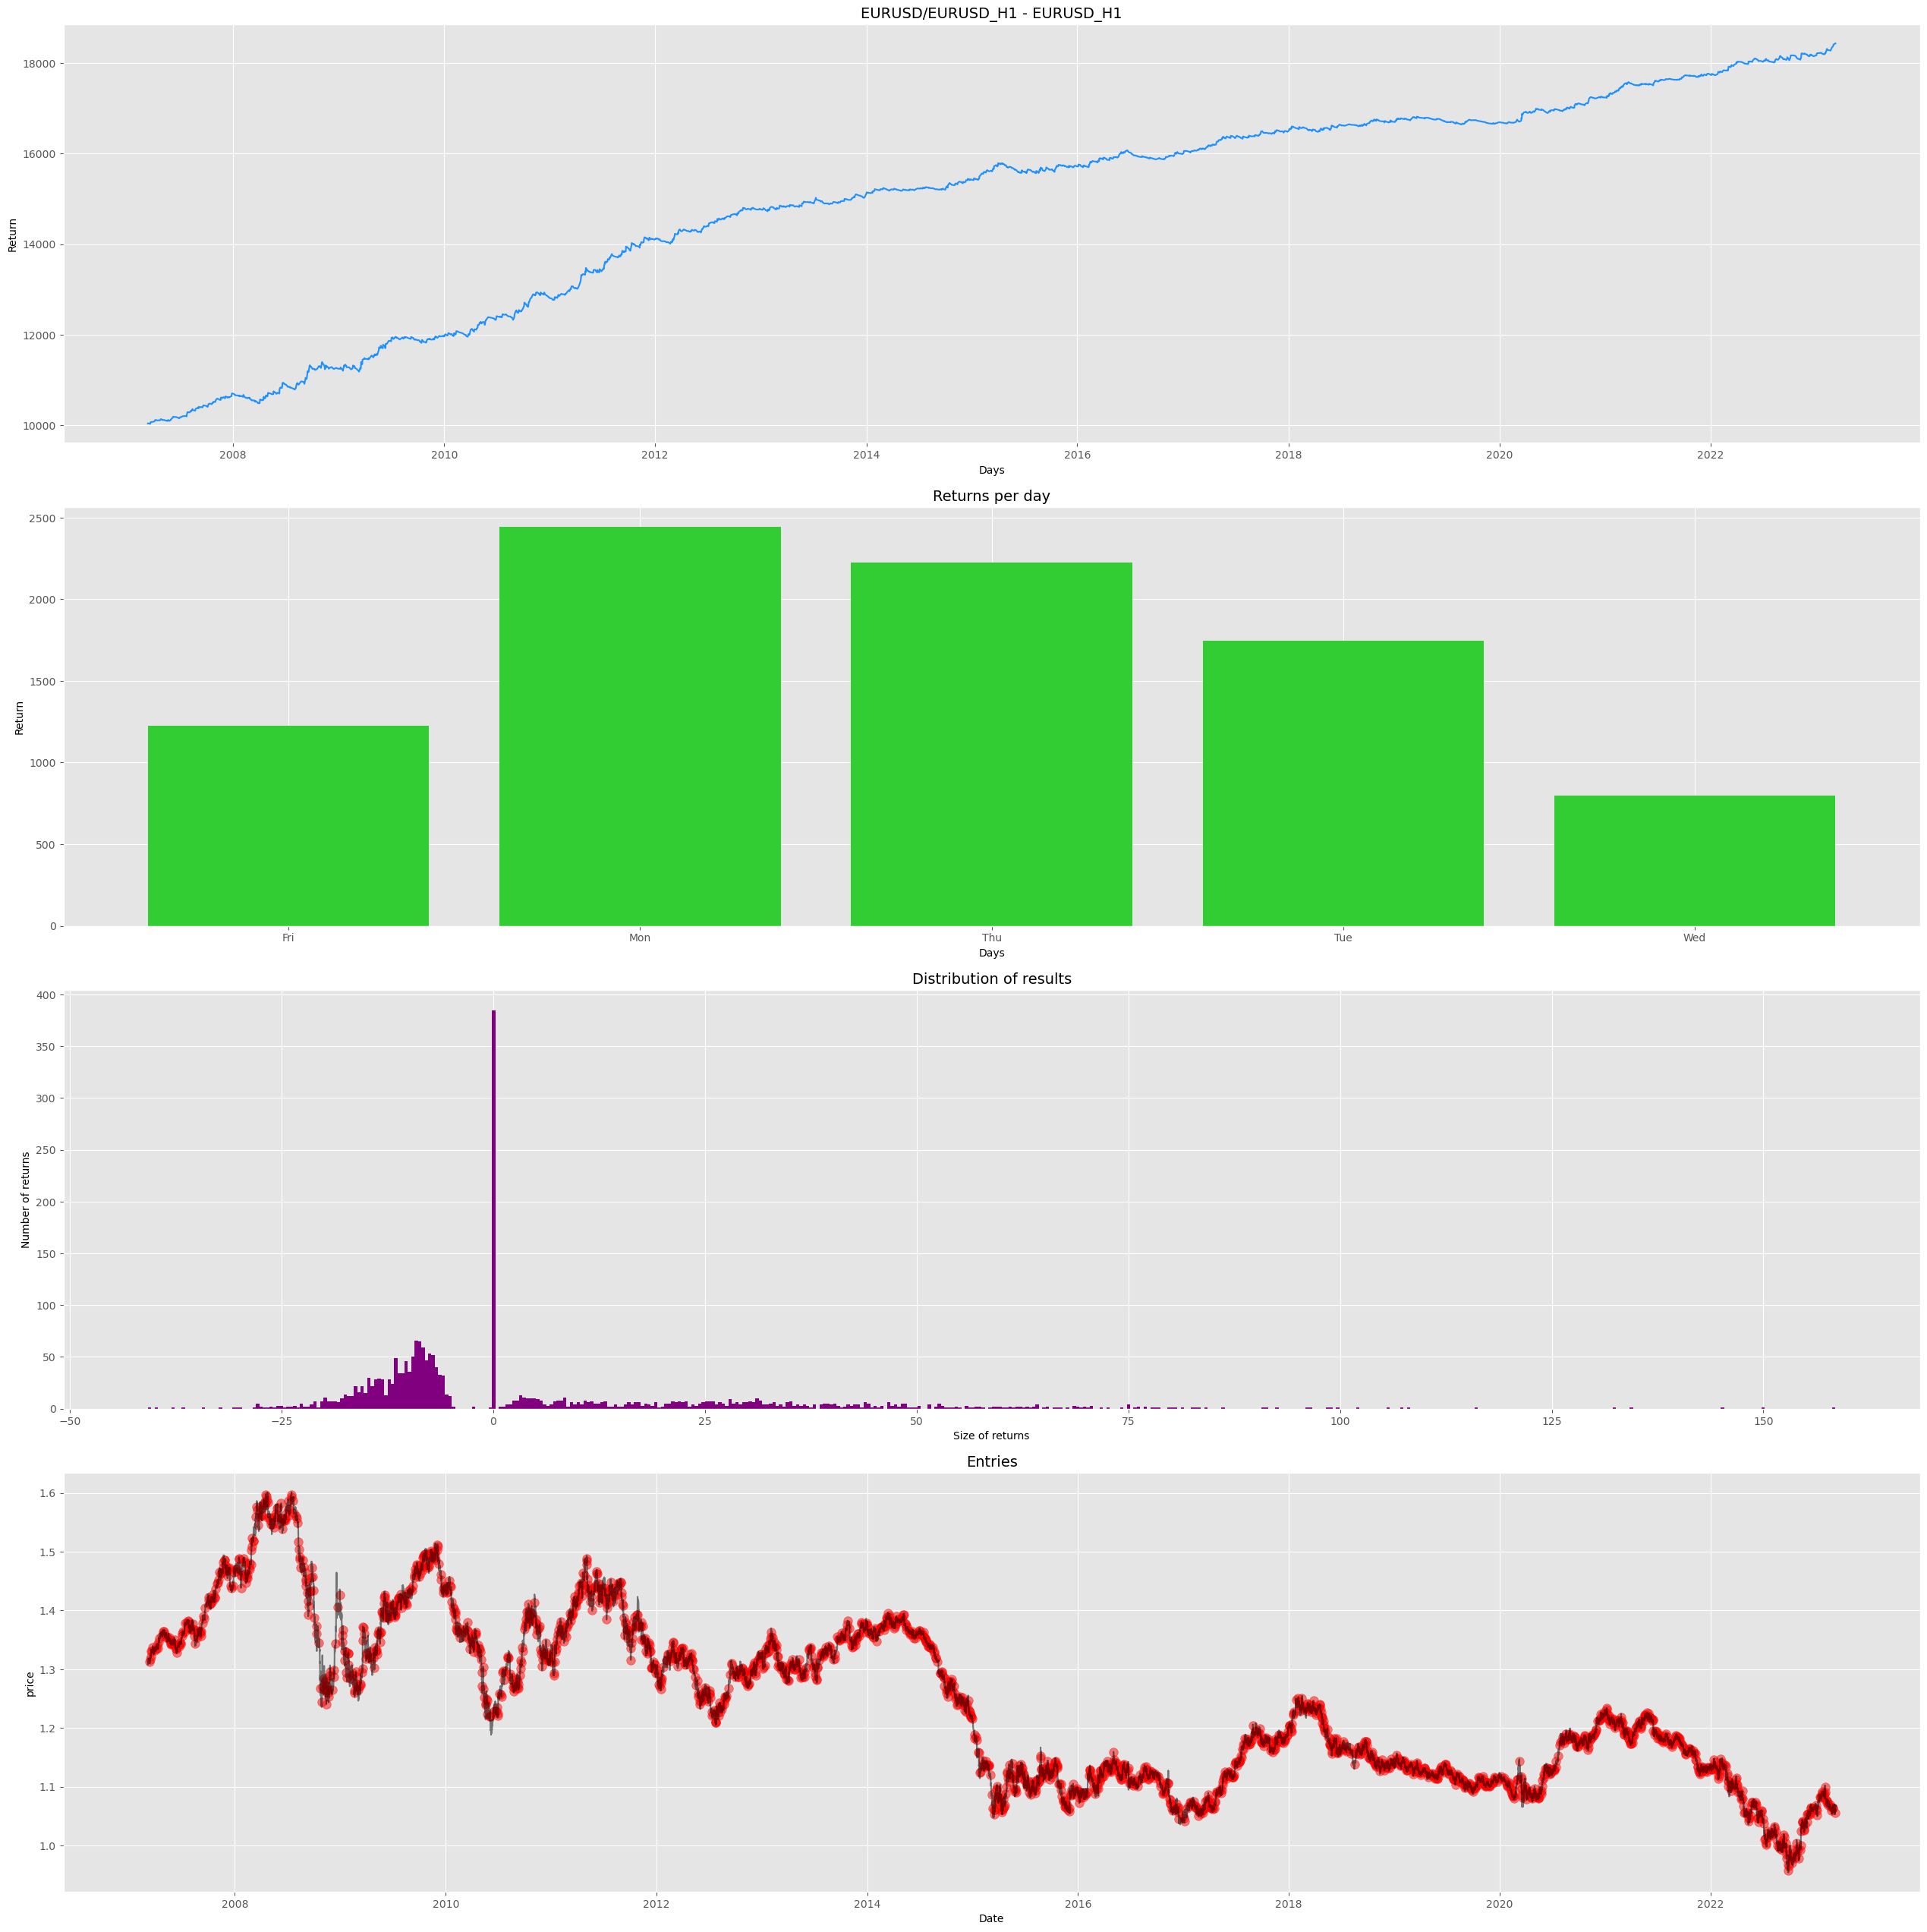

AUDUSD/AUDUSD_H1 - AUDUSD_H1 - PERFORMANCE
--------------------------------
Number of trades: 1843
Number of profits: 564
Number of losses: 914
Number of breakevens: 365 

Winning percentage 38.16 %
ROI: 4841.02
--------------------------------
Average profitable trade: 26.65
Average lossing trade: -11.15
Max profitable trade: 217.45
Max lossing trade: -43.69
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    360
Mon    384
Thu    374
Tue    356
Wed    369
Name: result, dtype: int64


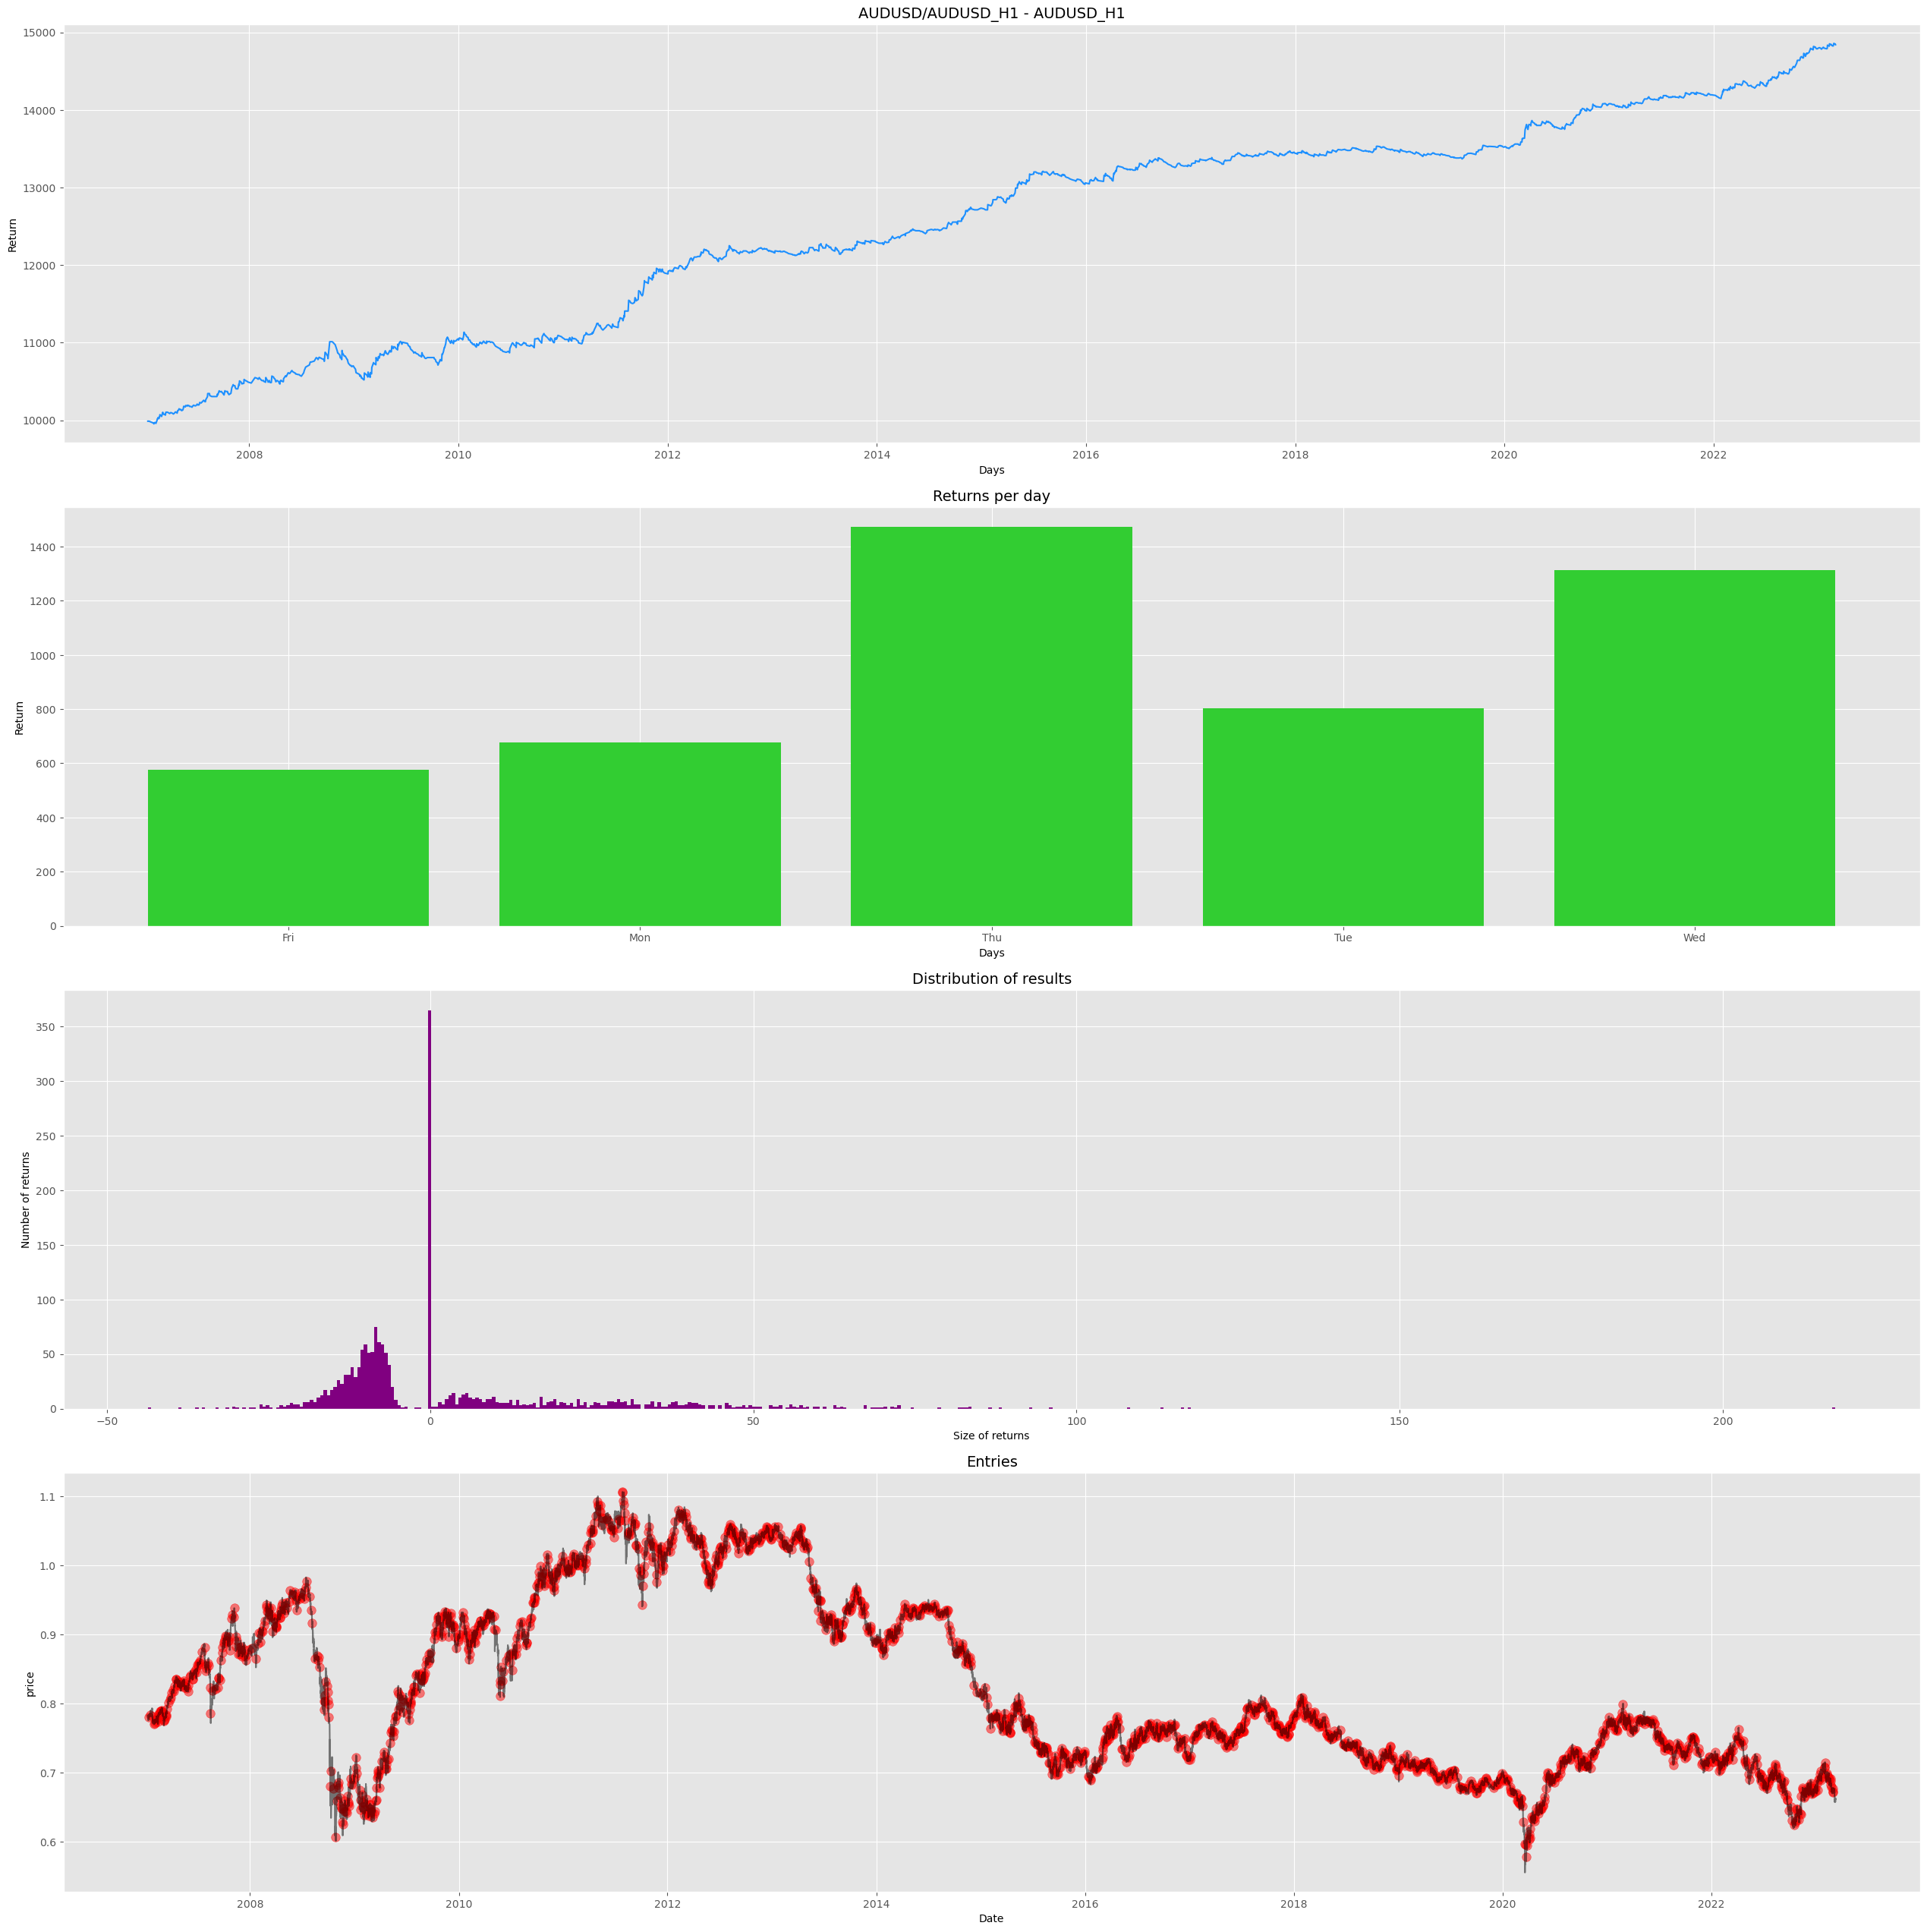

GBPUSD/GBPUSD_H1 - GBPUSD_H1 - PERFORMANCE
--------------------------------
Number of trades: 2367
Number of profits: 787
Number of losses: 1205
Number of breakevens: 375 

Winning percentage 39.51 %
ROI: 13615.46
--------------------------------
Average profitable trade: 37.75
Average lossing trade: -13.35
Max profitable trade: 238.69
Max lossing trade: -70.08
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    476
Mon    485
Thu    438
Tue    491
Wed    477
Name: result, dtype: int64


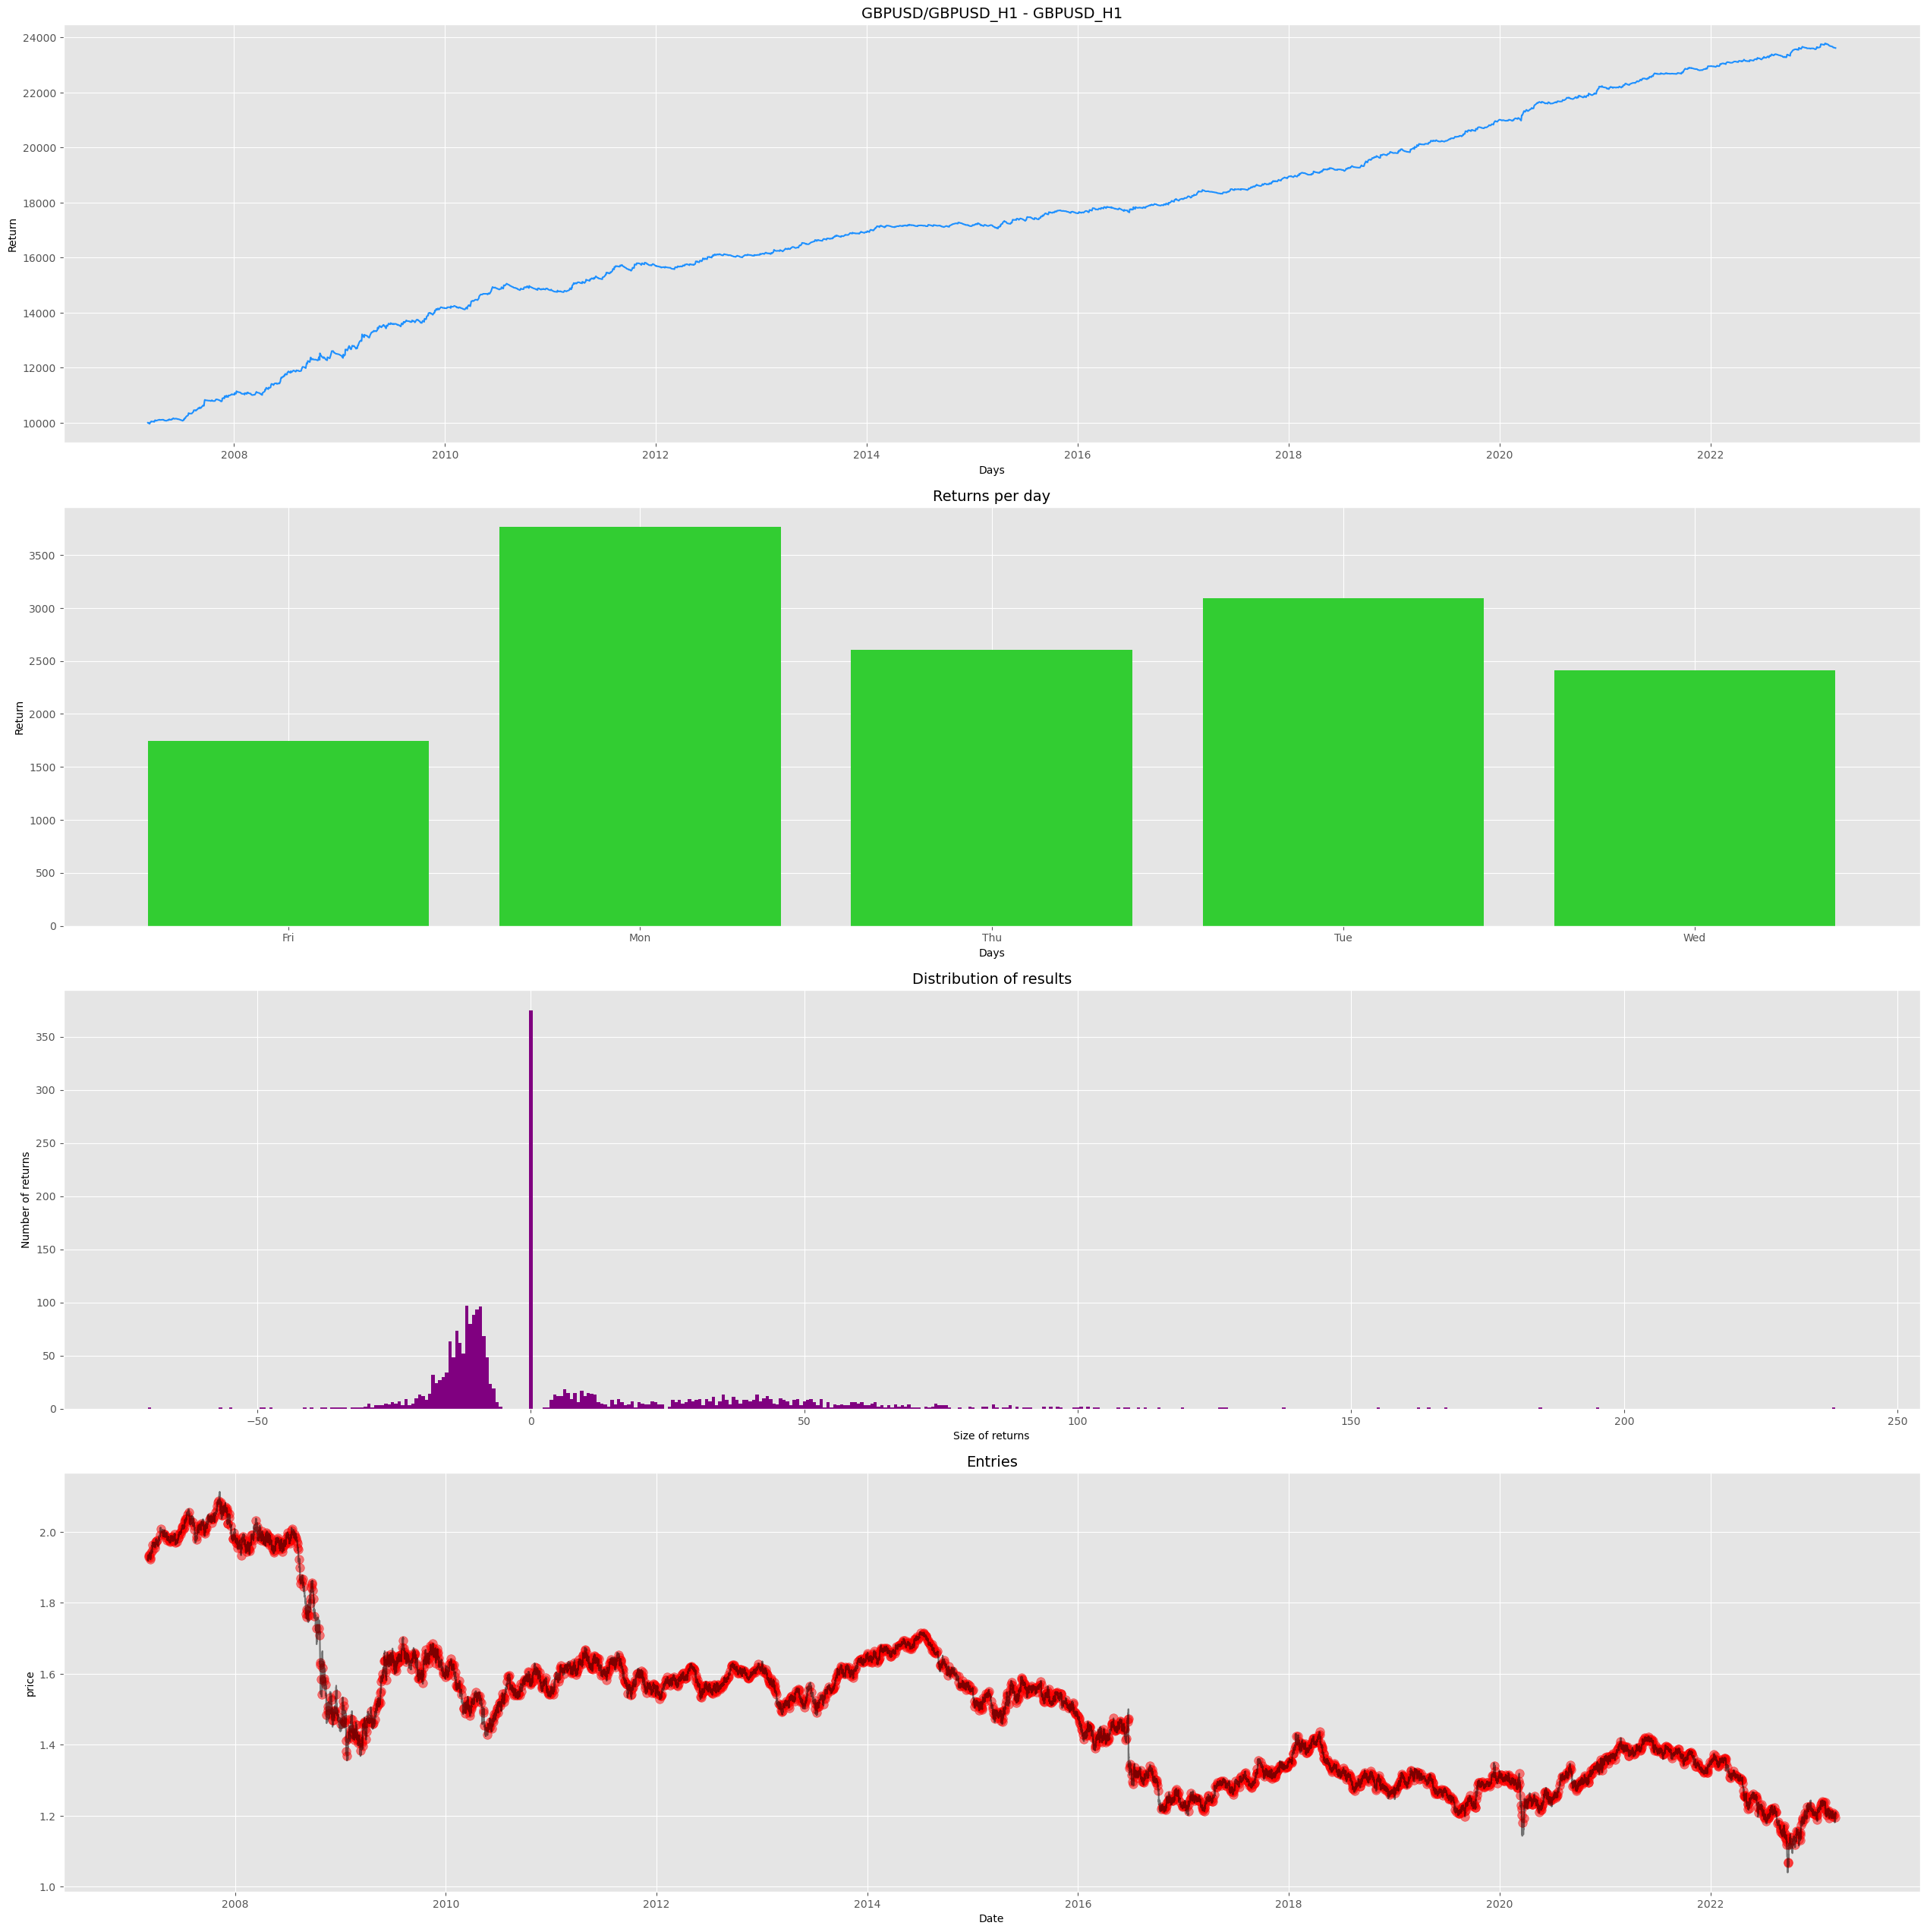

NZDUSD/NZDUSD_H1 - NZDUSD_H1 - PERFORMANCE
--------------------------------
Number of trades: 1928
Number of profits: 614
Number of losses: 945
Number of breakevens: 369 

Winning percentage 39.38 %
ROI: 5357.89
--------------------------------
Average profitable trade: 25.21
Average lossing trade: -10.71
Max profitable trade: 160.67
Max lossing trade: -45.28
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    371
Mon    398
Thu    387
Tue    388
Wed    384
Name: result, dtype: int64


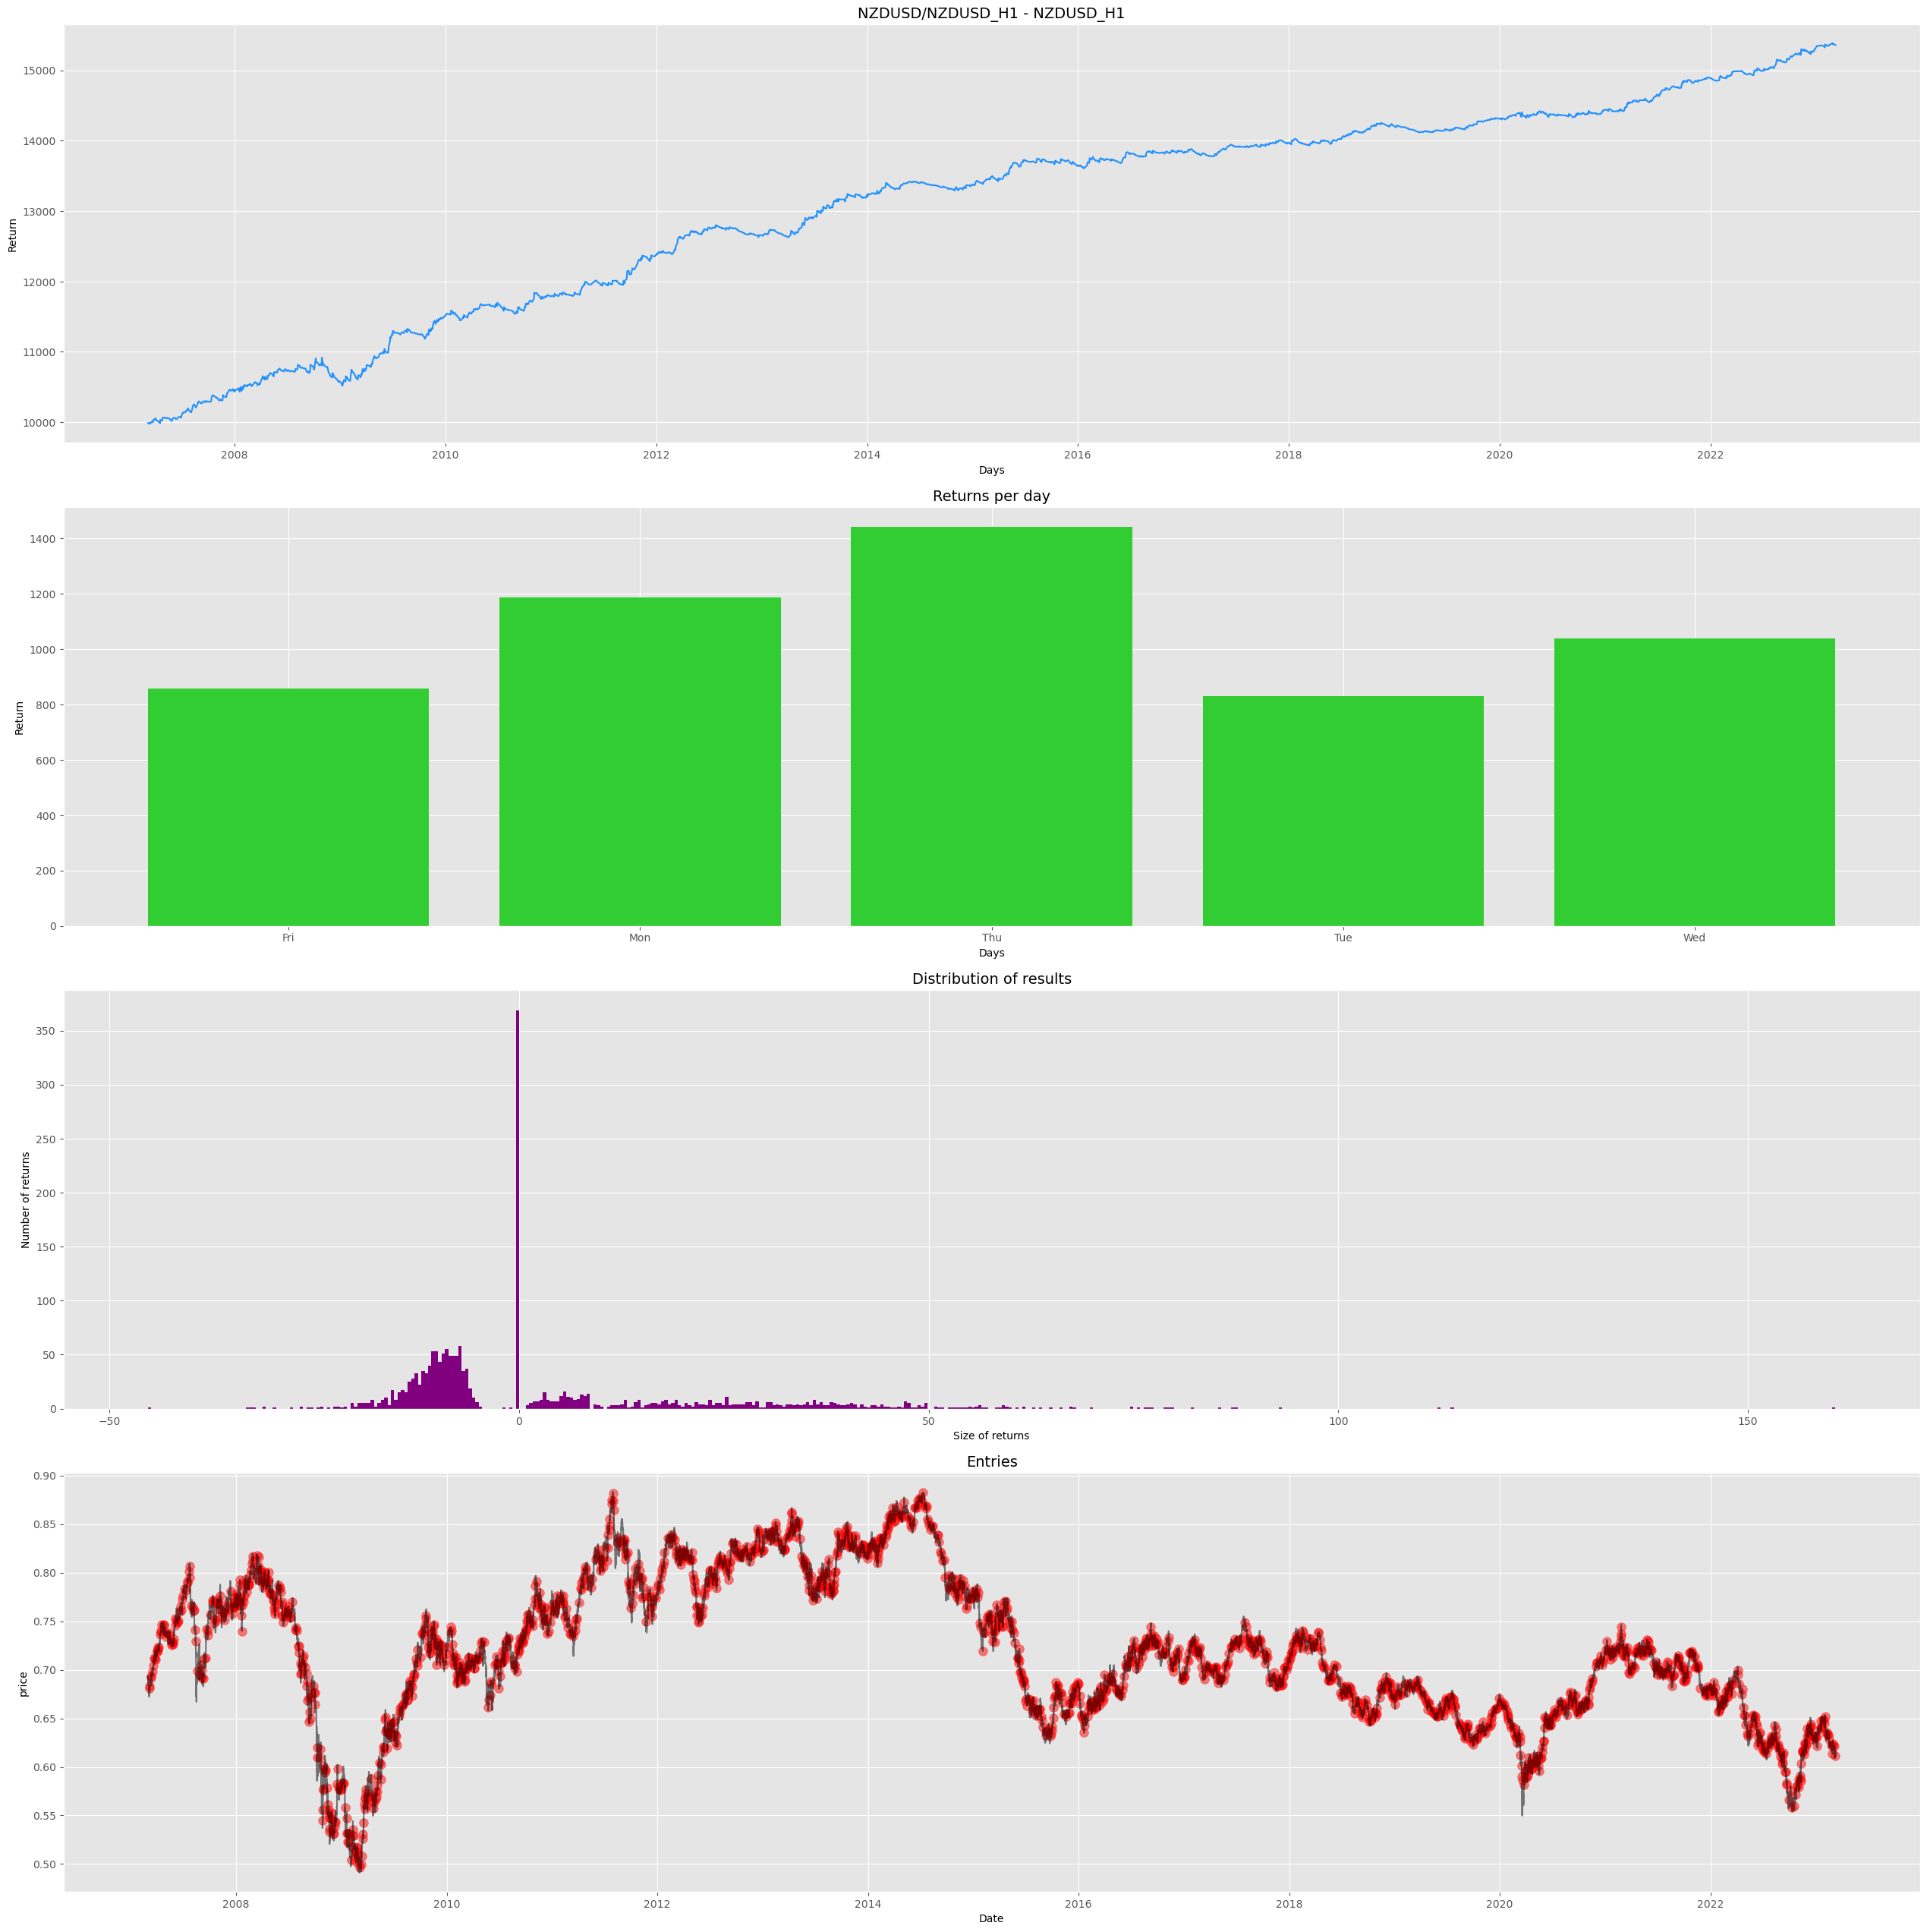

USDCAD/USDCAD_H1 - USDCAD_H1 - PERFORMANCE
--------------------------------
Number of trades: 2186
Number of profits: 582
Number of losses: 1117
Number of breakevens: 487 

Winning percentage 34.26 %
ROI: 4007.46
--------------------------------
Average profitable trade: 28.57
Average lossing trade: -11.3
Max profitable trade: 127.0
Max lossing trade: -53.43
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    433
Mon    440
Thu    446
Tue    448
Wed    419
Name: result, dtype: int64


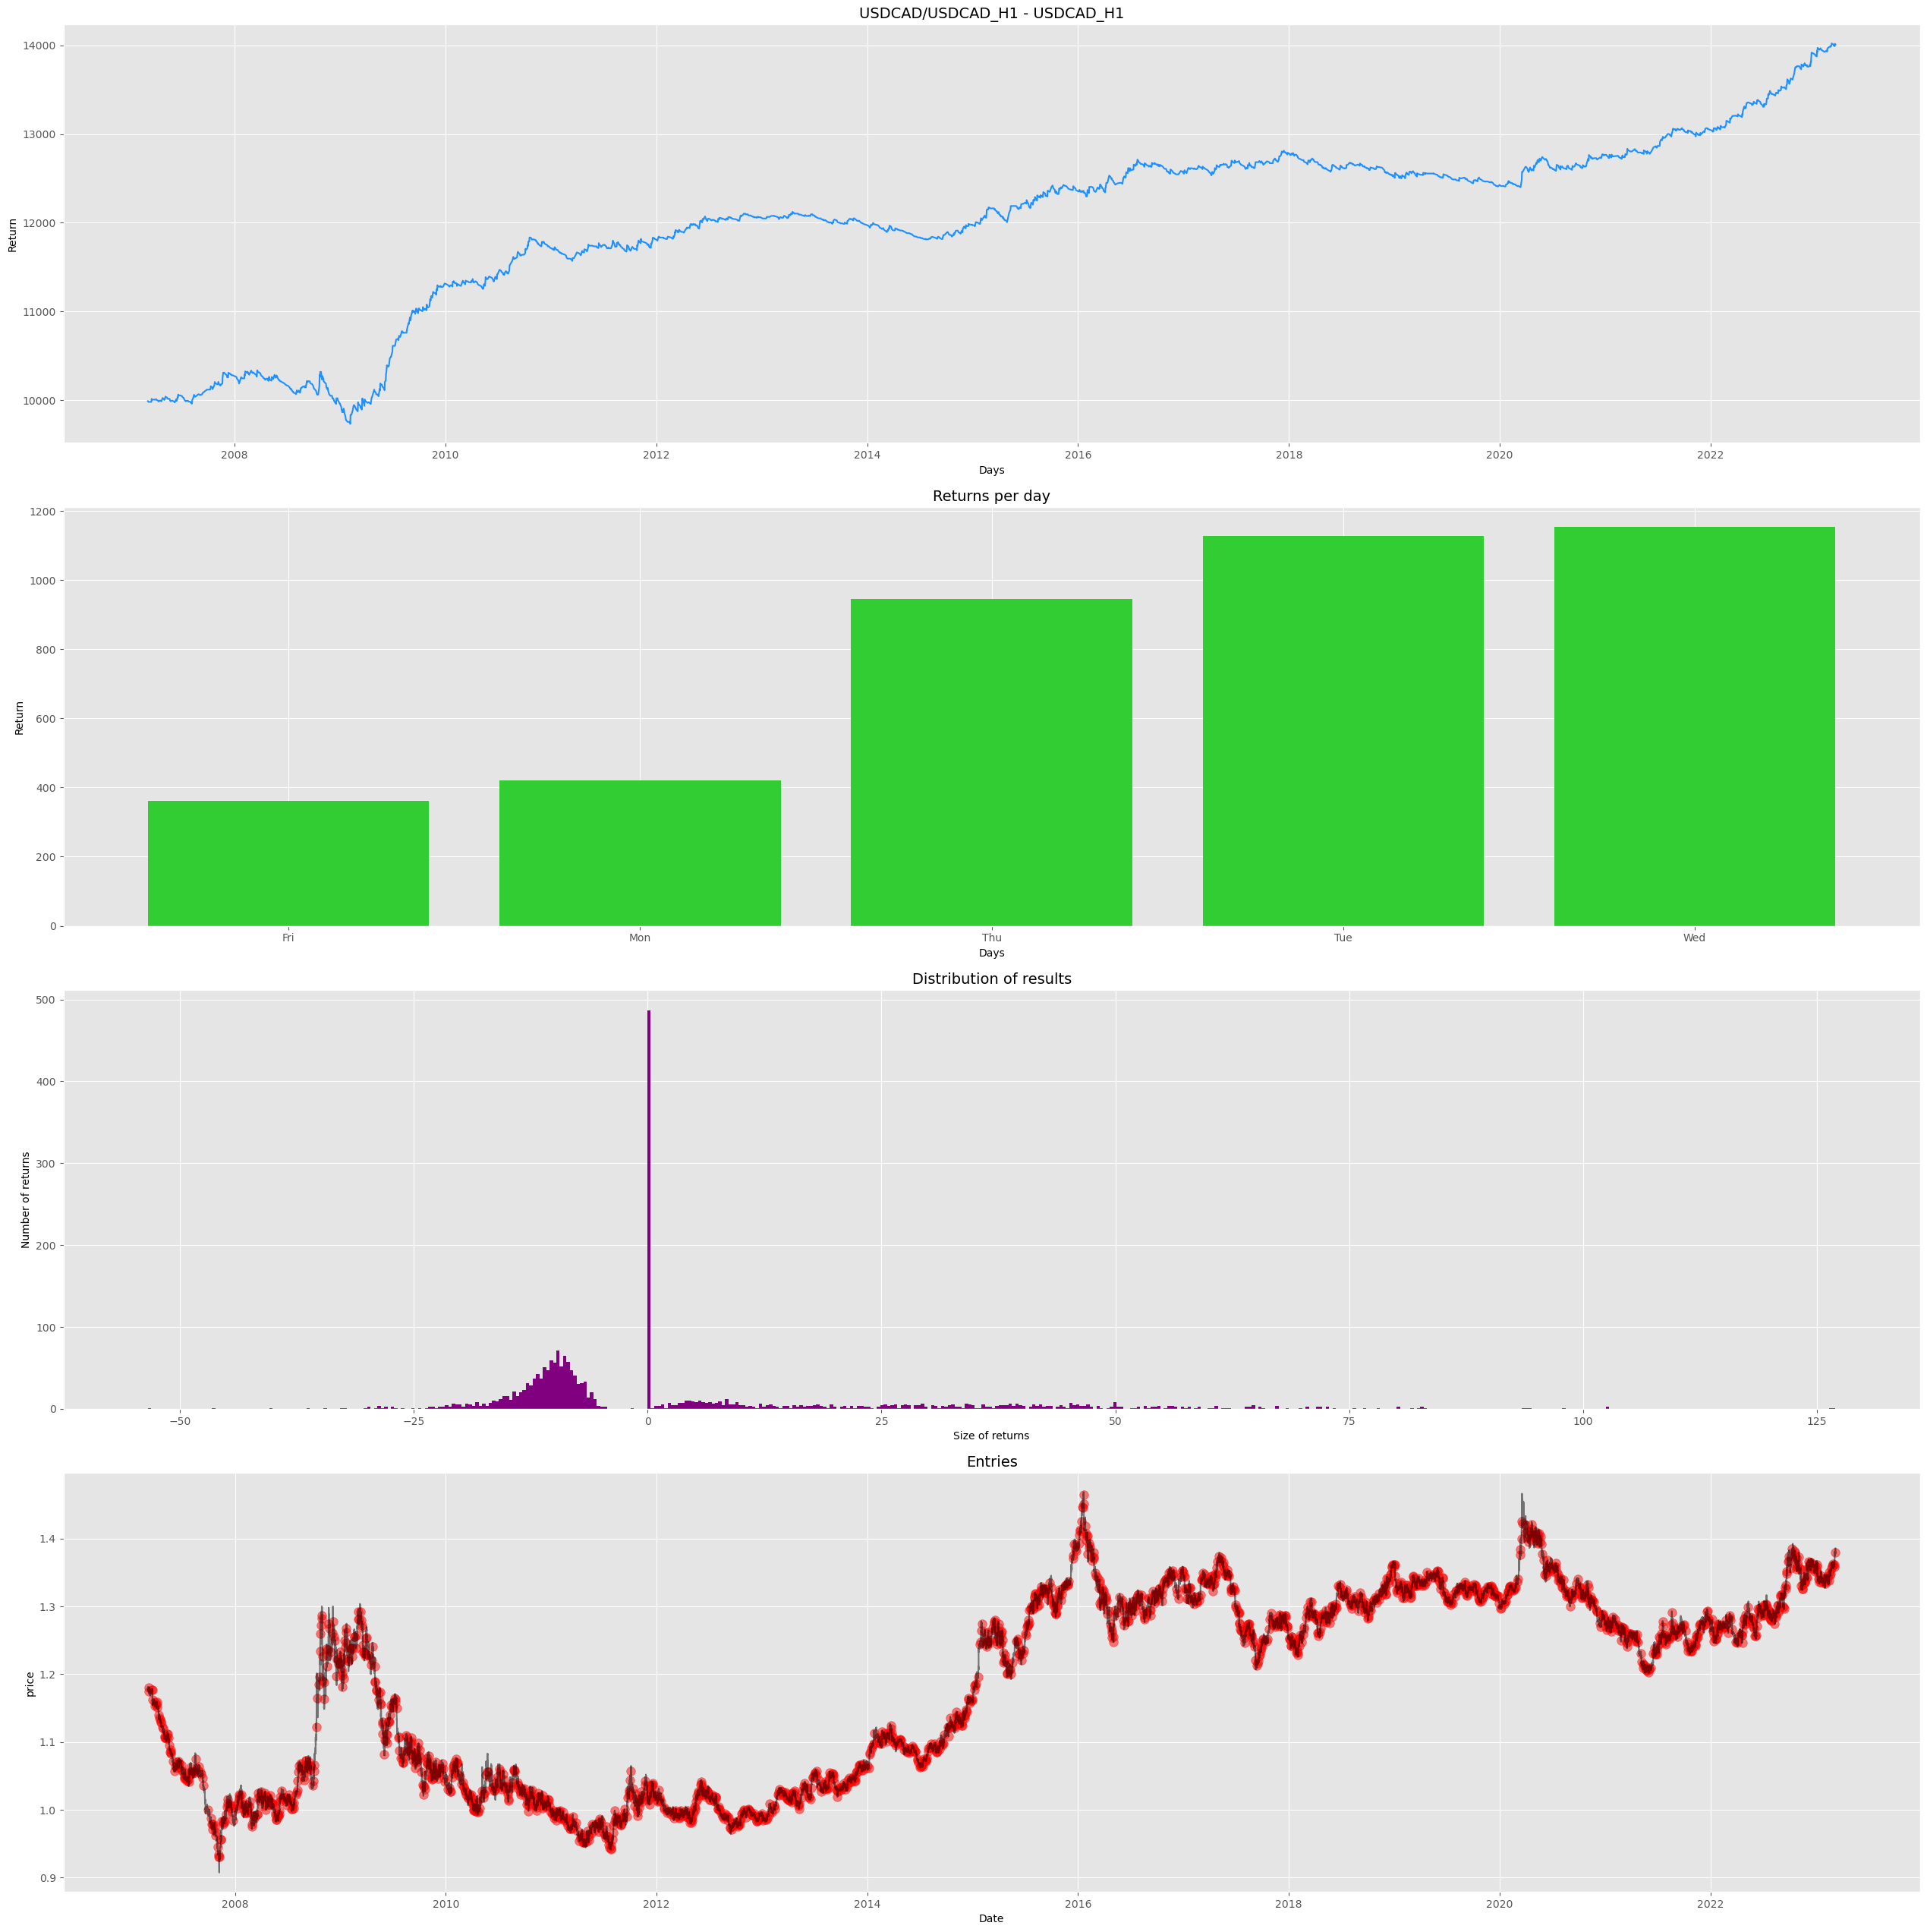

USDCHF/USDCHF_H1 - USDCHF_H1 - PERFORMANCE
--------------------------------
Number of trades: 2330
Number of profits: 775
Number of losses: 1137
Number of breakevens: 418 

Winning percentage 40.53 %
ROI: 8305.48
--------------------------------
Average profitable trade: 25.13
Average lossing trade: -9.82
Max profitable trade: 142.91
Max lossing trade: -34.05
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    448
Mon    466
Thu    490
Tue    479
Wed    447
Name: result, dtype: int64


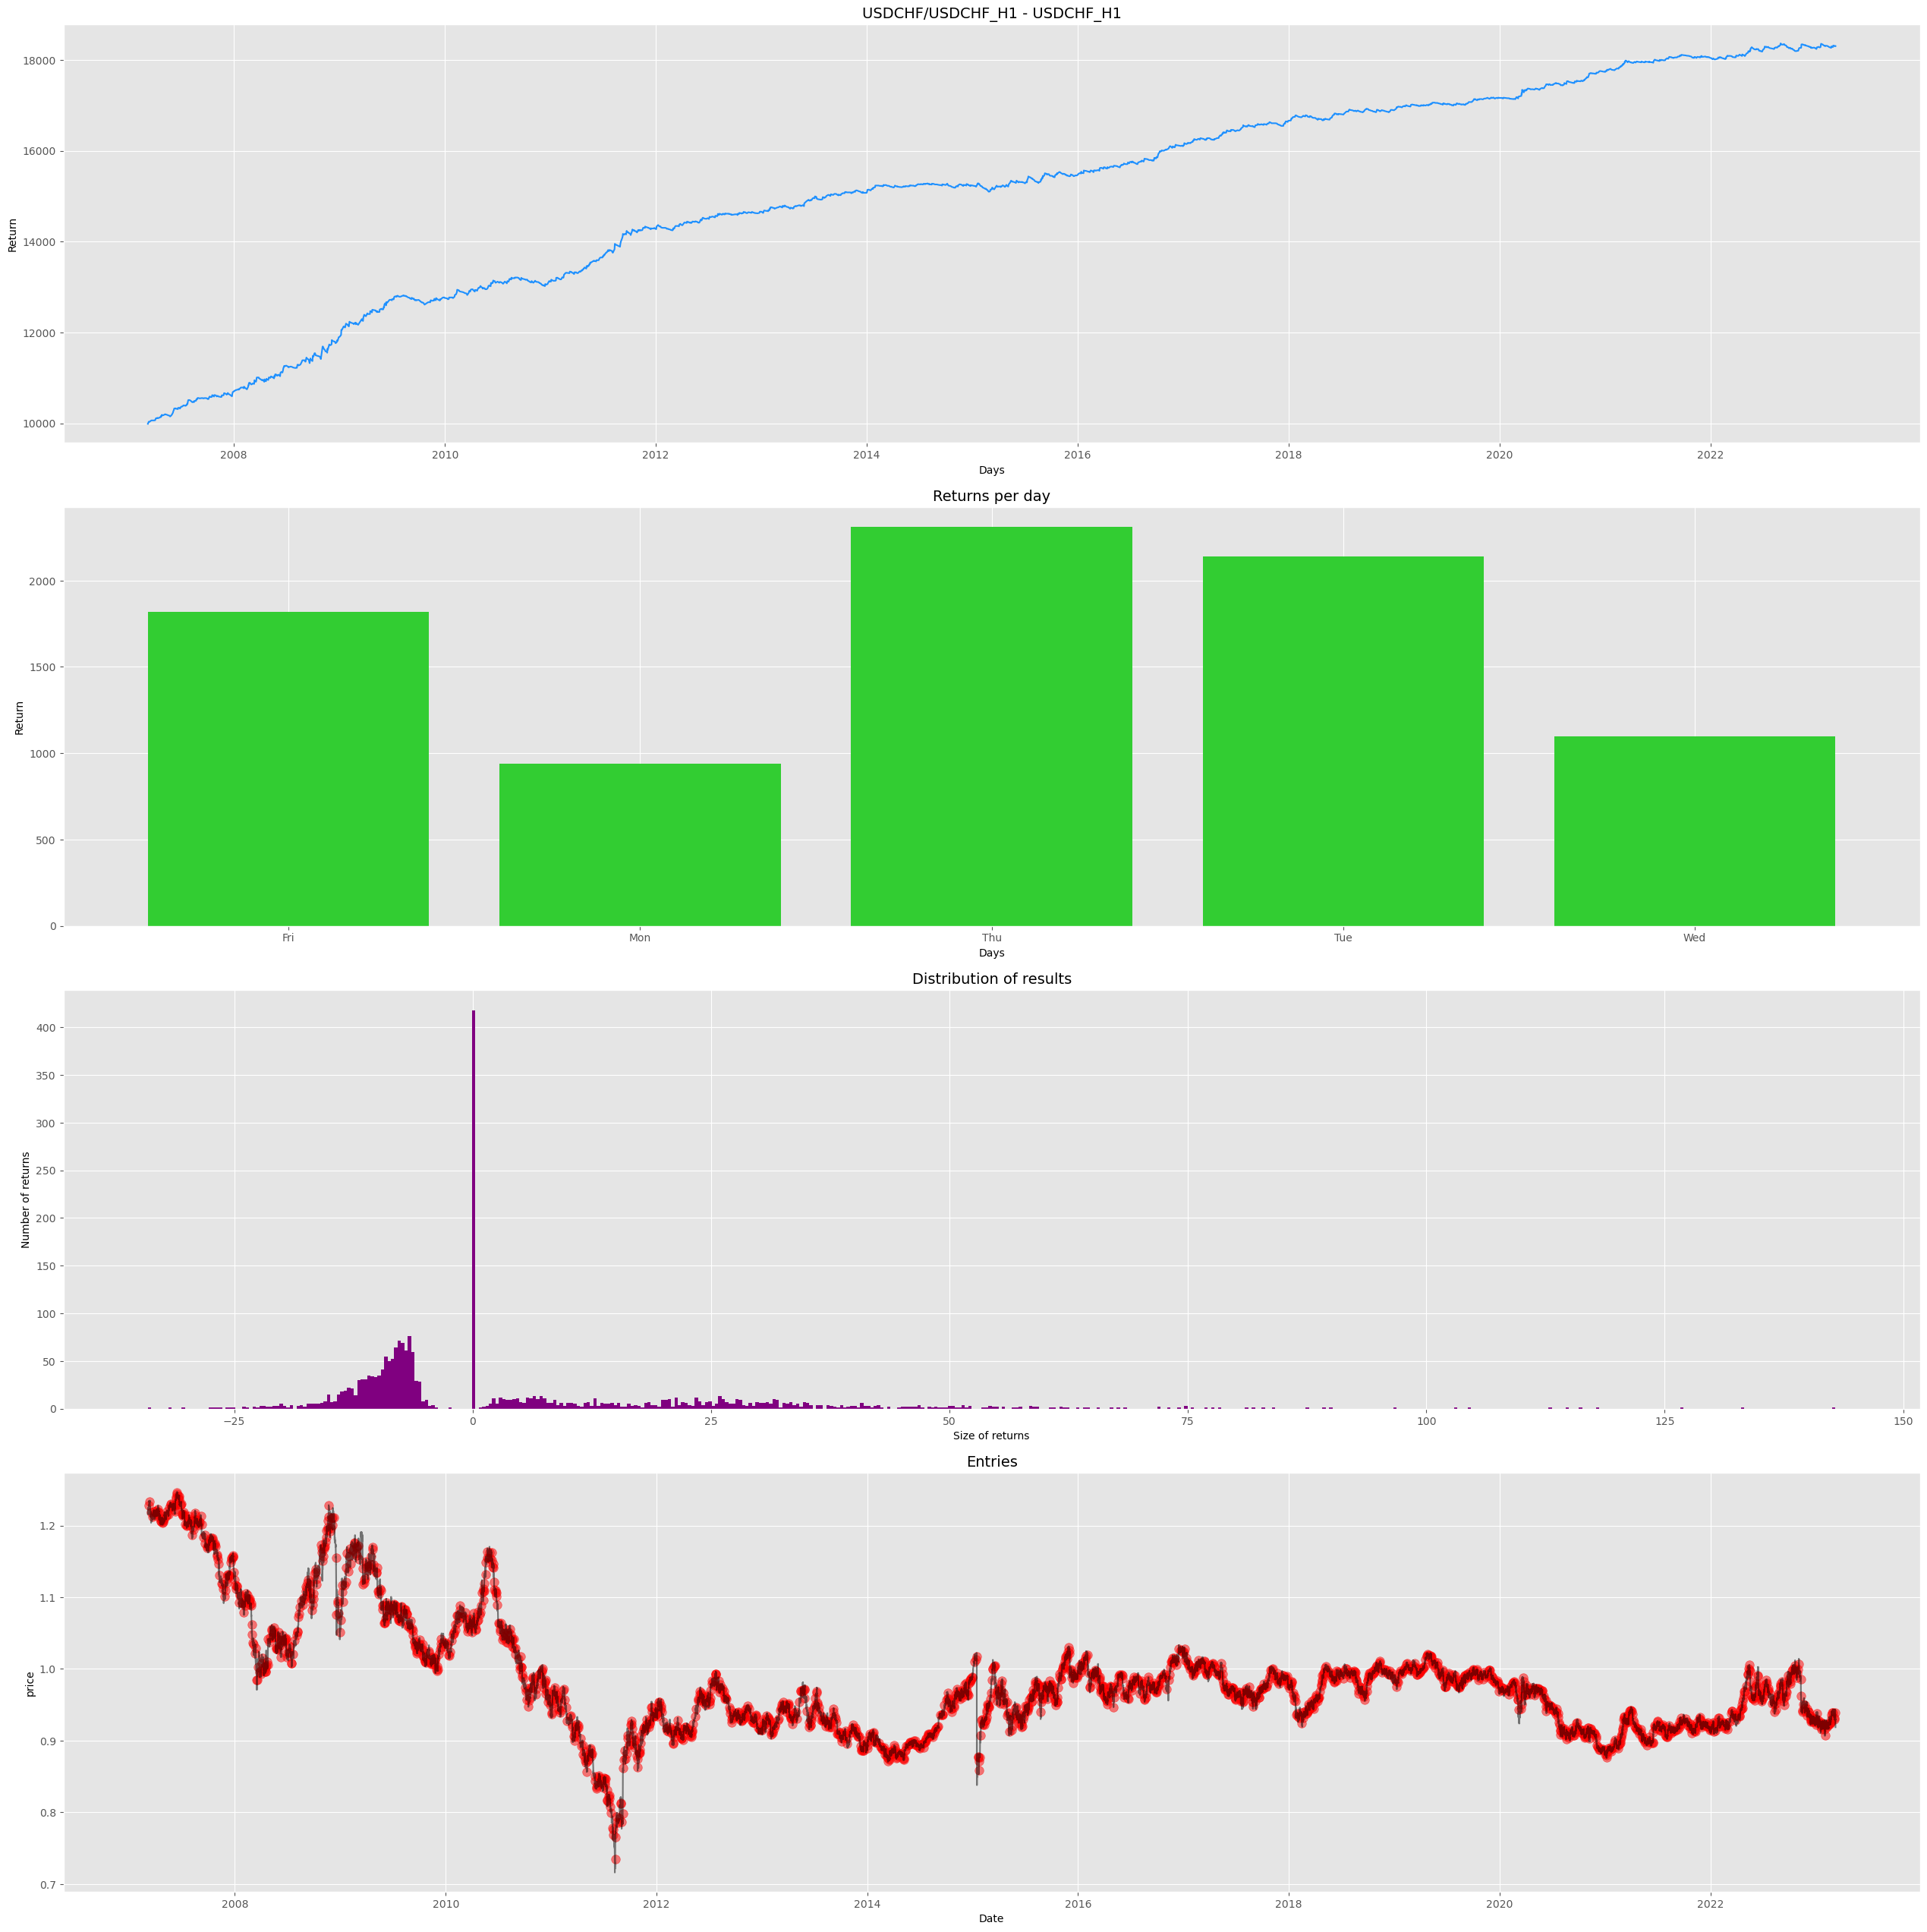

USDJPY/USDJPY_H1 - USDJPY_H1 - PERFORMANCE
--------------------------------
Number of trades: 1904
Number of profits: 601
Number of losses: 909
Number of breakevens: 394 

Winning percentage 39.8 %
ROI: 6486.17
--------------------------------
Average profitable trade: 26.86
Average lossing trade: -10.62
Max profitable trade: 191.61
Max lossing trade: -36.78
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    376
Mon    385
Thu    372
Tue    395
Wed    376
Name: result, dtype: int64


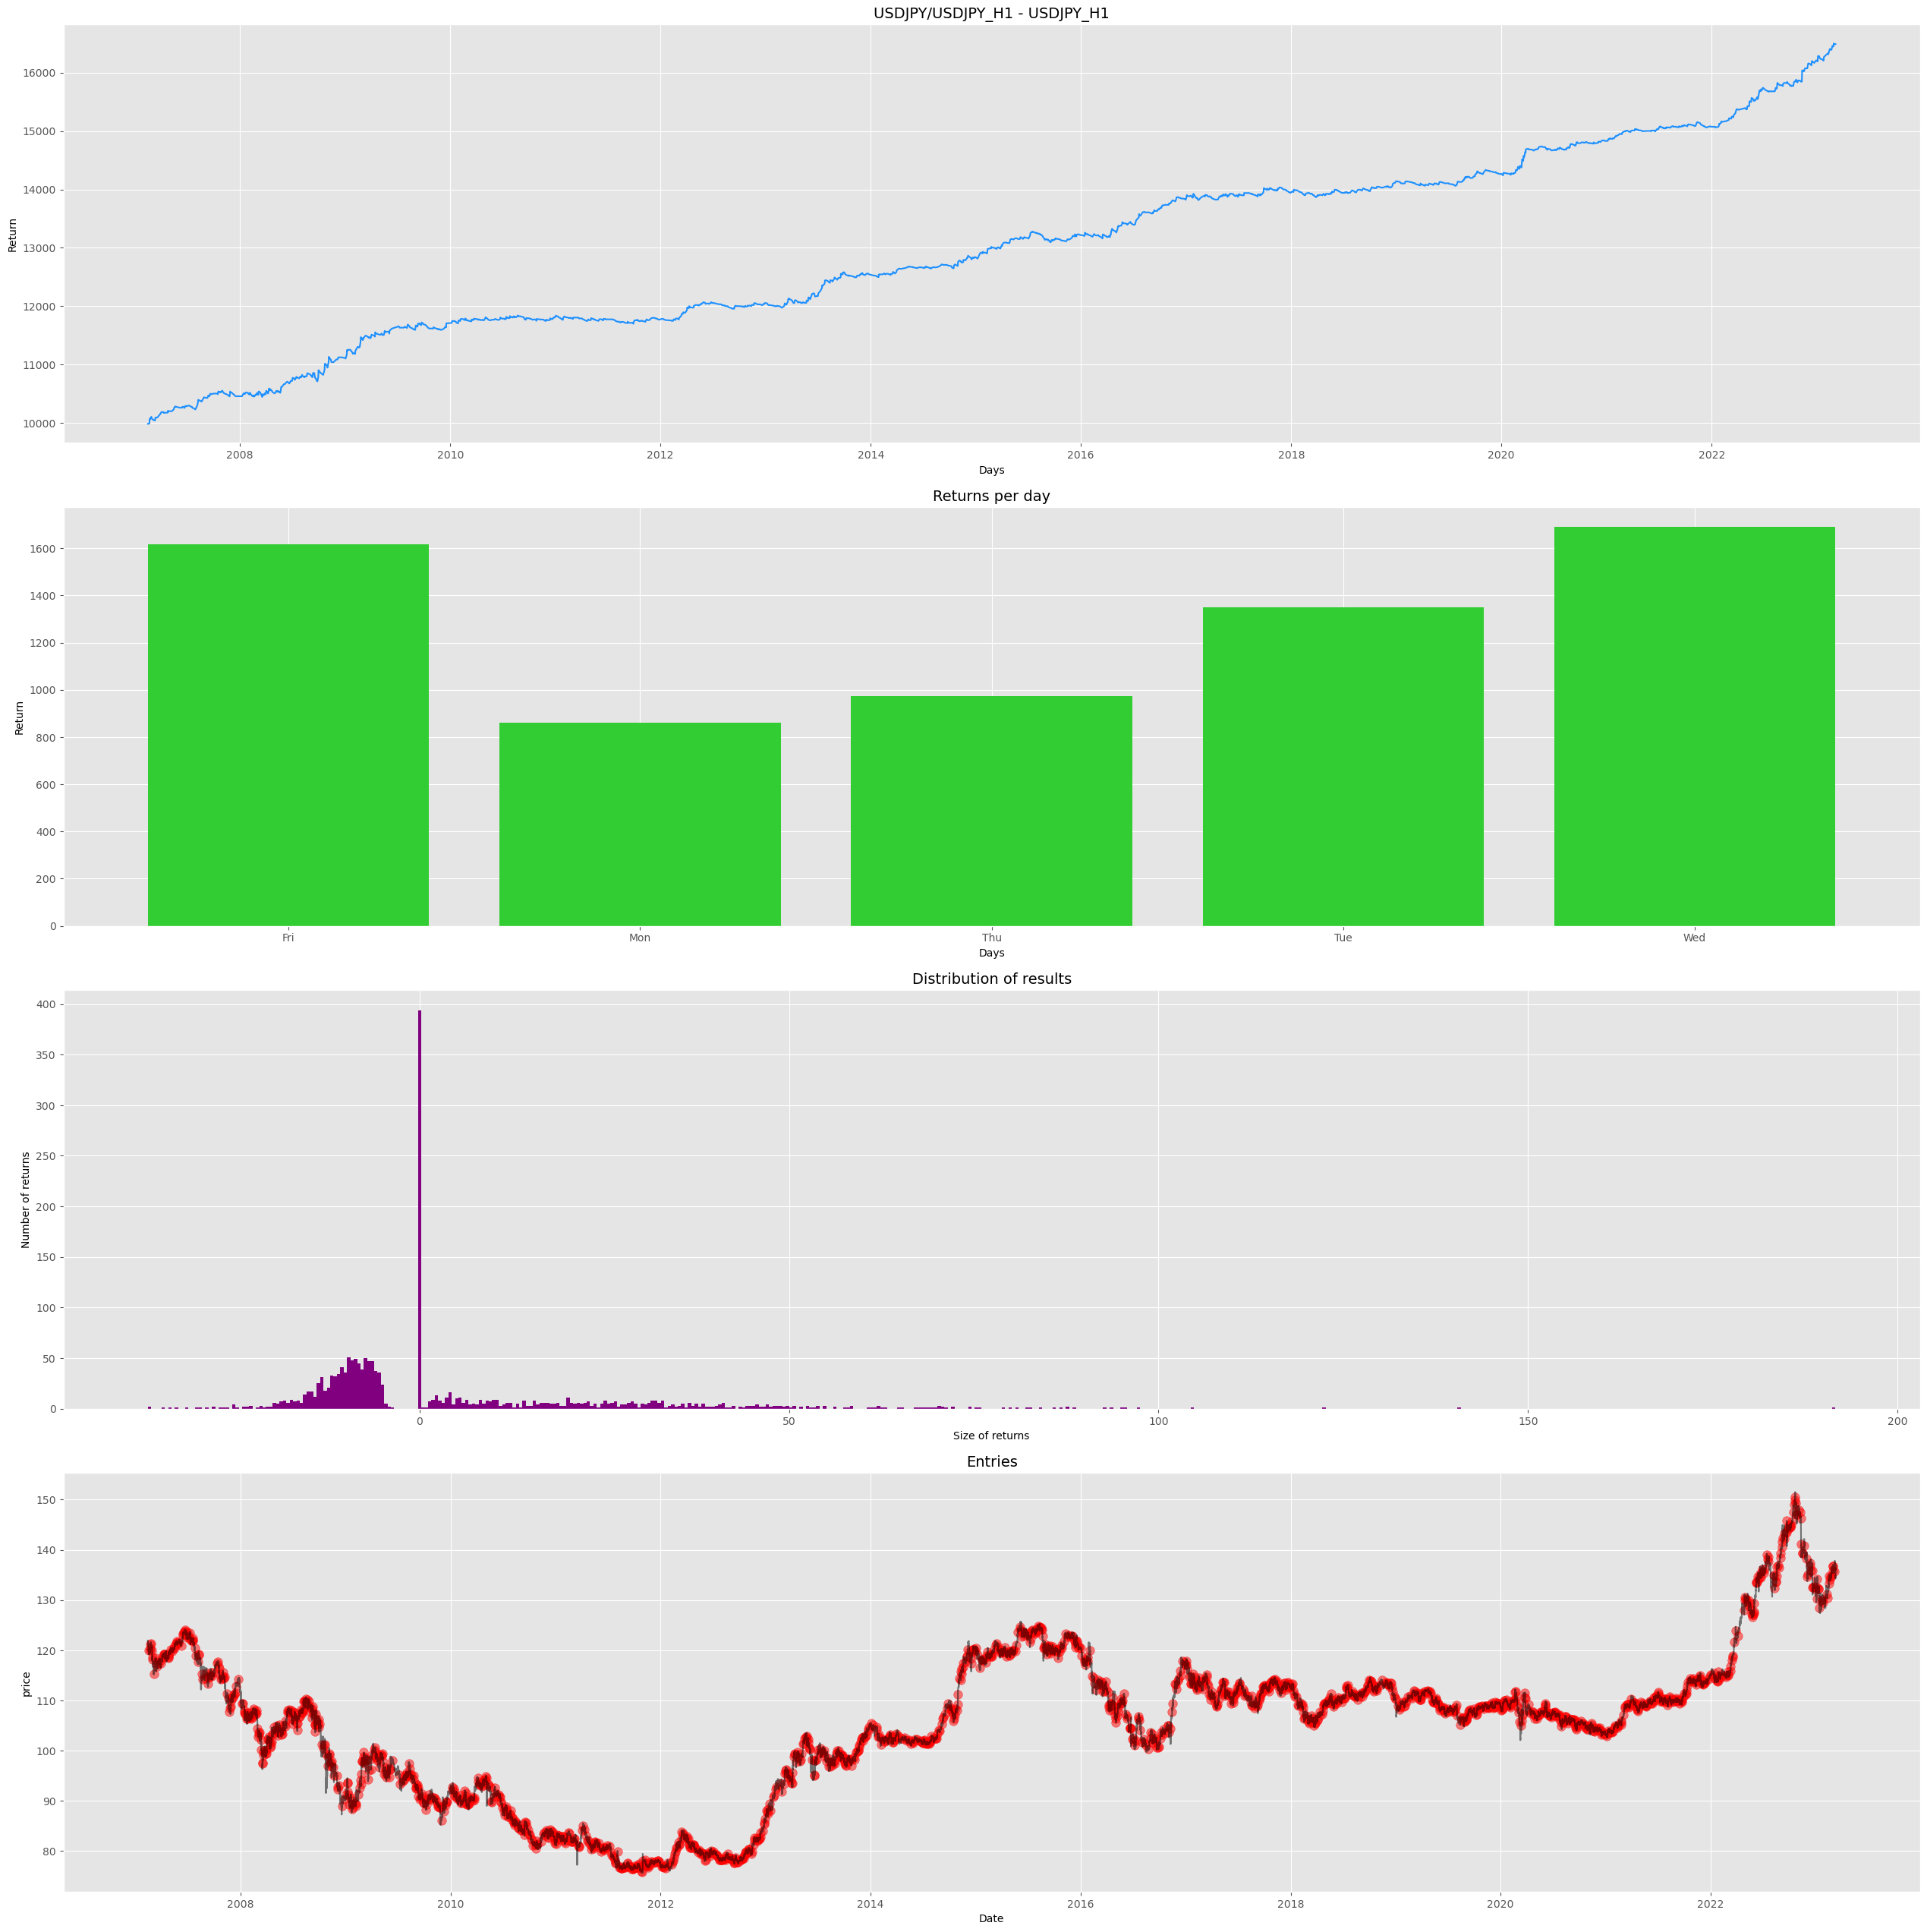

XAUUSD/XAUUSD_H1 - XAUUSD_H1 - PERFORMANCE
--------------------------------
Number of trades: 2012
Number of profits: 633
Number of losses: 1001
Number of breakevens: 378 

Winning percentage 38.74 %
ROI: 20707018.0
--------------------------------
Average profitable trade: 62105.55
Average lossing trade: -18587.21
Max profitable trade: 514009.25
Max lossing trade: -88750.0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Number of trades per day 
 day_of_trade
Fri    391
Mon    391
Thu    399
Tue    443
Wed    388
Name: result, dtype: int64


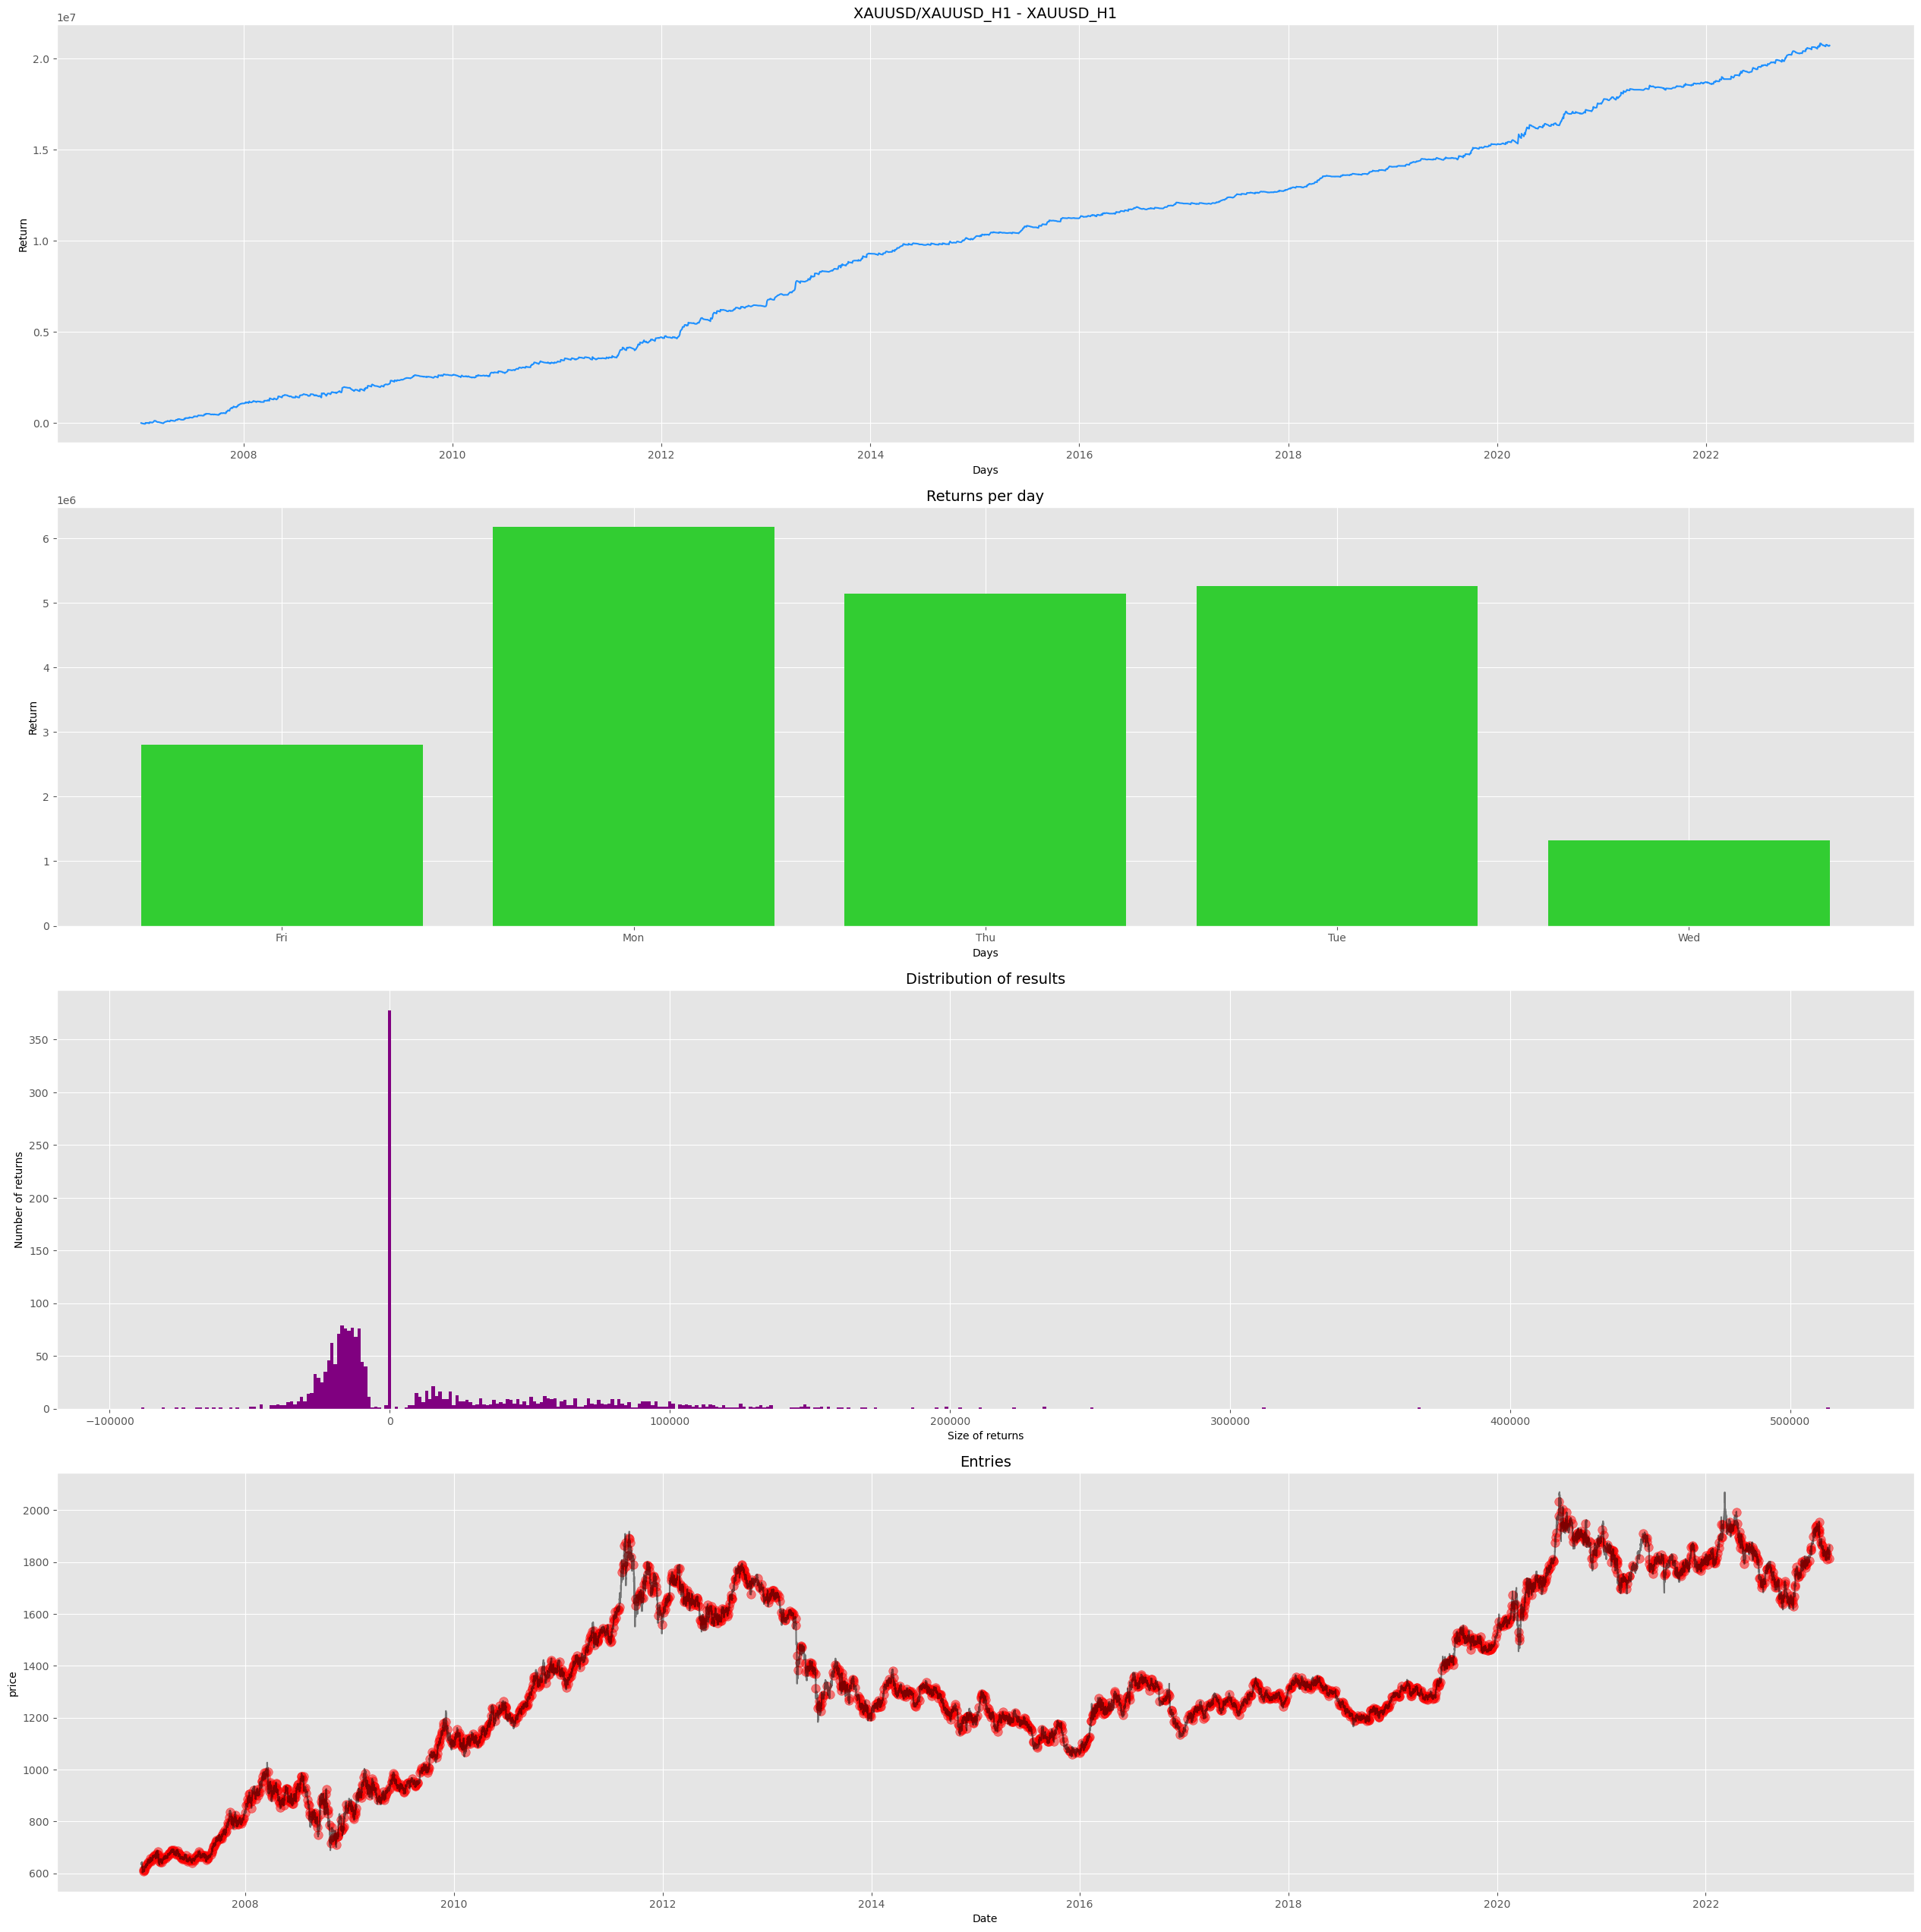

In [15]:
#performance for each pair
for pair in range(len(pairs_list)):
    print(pairs_list[pair], '- PERFORMANCE')
    print('--------------------------------')
    print('Number of trades:', len(profits[pair] + losses[pair] + be[pair]))
    print('Number of profits:', len(profits[pair]))
    print('Number of losses:', len(losses[pair]))
    print('Number of breakevens:', len(be[pair]), '\n')
    print('Winning percentage', (round(len(profits[pair]) / (len(profits[pair]) + len(losses[pair])) * 100, 2)), '%')
    print('ROI:', round(pairs_results[pair]['cum_res'][-1] - account_size, 2))
    print('--------------------------------')
    print('Average profitable trade:', round(sum(profits[pair]) / len(profits[pair]), 2))
    print('Average lossing trade:', round(sum(losses[pair]) / len(losses[pair]), 2))
    print('Max profitable trade:', round(max(profits[pair]), 2))
    print('Max lossing trade:', round(min(losses[pair]), 2))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx \n')
    
    trades_per_day = pairs_results[pair].groupby('day_of_trade').count()['result']
    day_return = pairs_results[pair].groupby('day_of_trade').sum()['result']
    day_return_positive = day_return > 0
    
    print('Number of trades per day \n', trades_per_day)
    
    fig, axes = plt.subplots(4, 1, figsize = (26, 26))
    fig.tight_layout(pad = 4)
    
    axes[0].plot(pairs_results[pair]['cum_res'], color = 'dodgerblue')
    axes[0].set_title(pairs_list[pair], fontsize = 14)
    axes[0].set_xlabel('Days')
    axes[0].set_ylabel('Return')
    
    axes[1].bar(day_return.keys(), height = day_return, color = day_return_positive.map({True: 'limegreen', False: 'coral'}))
    axes[1].set_title('Returns per day', fontsize = 14)
    axes[1].set_xlabel('Days')
    axes[1].set_ylabel('Return')
    
    axes[2].hist(pairs_results[pair]['result'], bins = 500, color = 'purple')
    axes[2].set_title('Distribution of results', fontsize = 14)
    axes[2].set_xlabel('Size of returns')
    axes[2].set_ylabel('Number of returns')
    
    axes[3].plot(df[pair]['Close'], color = 'black', alpha = 0.5)
    axes[3].scatter(pairs_results[pair].index, pairs_results[pair]['entry_price'], s = 70, color = 'red', alpha = 0.5)
    axes[3].set_title('Entries', fontsize = 14)
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('price')
    
    plt.show()